KEERTHI'S NOTEBOOK

## 1.1 Importing dependancies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

#libraries for NLP
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import HTML
!pip install chart_studio
import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
plotly.offline.init_notebook_mode(connected=True)
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.express as px
from collections import defaultdict
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 64 kB 274 kB/s 


## 1.2 Reading and preparation of data

Reading [data](https://www.kaggle.com/c/nlp-getting-started/data) and choosing important columns using [pandas](https://pandas.pydata.org/)

In [2]:
data = pd.read_csv('../input/nlp-getting-started/train.csv')

Displaying first 10 rows of our data using [DataFrame.head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)

In [3]:
data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Concise summarization of total information provided by the data using [DataFrame.info()](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.info.html)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


We only use text and target column of dataset for rest of our work as there lot's of null values inside other columns

In [5]:
data = data[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


## 2. Data Exploration

## 2.1 Visualising counts of real and fake tweets

Let's plot the counts of values under the target column

In [6]:
fig = px.bar(x=["0","1"], y=data["target"].value_counts(),color=["red", "goldenrod"])

#Change this value for bar widths
for dt in fig.data:
    dt["width"] = 0.4 

fig.update_layout(
    title_text = "Counts for Disaster and Non-Disaster Tweets",
    title_x=0.5,
    width=800,
    height=550,
    xaxis_title="Targets",
    yaxis_title="Count",
    showlegend=False
).show()

# py.plot(fig,filename='Counts for Disaster and Non-Disaster Tweets',auto_open=False,show_link=False)

## 2.2 Visualising lengths of tweets

Analyzing lengths of words in a tweets according to it being real or fake target value by ploting [histograms](https://plotly.com/python/histograms/)

In [7]:
from plotly.subplots import make_subplots

word_len_dis = data[data['target']==1]['text'].str.split().map(lambda x : len(x))

word_len_non_dis = data[data['target']==0]['text'].str.split().map(lambda x : len(x))

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
            go.Histogram(x=word_len_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=1
).add_trace(
            go.Histogram(x=word_len_non_dis,marker_line=dict(color='black'),marker_line_width=1.2),
            row=1, col=2
).update_layout(title_text="Length of words in Tweets",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Length of words in Tweets',auto_open=False,show_link=False)

## 2.3 Visualising most common stop words in the text data

In linguistics and NLP, corpus (literally Latin for body) refers to a collection of texts.   
Such collections may be formed of a single language of texts, or can span multiple languages
   
Function for creating sample [corpus](https://21centurytext.wordpress.com/home-2/special-section-window-to-corpus/what-is-corpus/) for further analysis.    

In [9]:
def create_corpus(target):
    corpus = []
    for i in data[data['target']==target]['text'].str.split():
        for x in i:
            corpus.append(x)
    return corpus

In [10]:
values_list = []

def analyze_stopwords(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        dic[word] += 1
    
    top = sorted(dic.items(),key = lambda x: x[1],reverse=True)[:10]
    x_items,y_values = zip(*top)
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing stopwords for 0 and 1 target labels
analyze_stopwords(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))

fig.add_trace(
      go.Bar(x=values_list[1],y=values_list[0],orientation='h',marker=dict(color= 'rgba(152, 255, 74,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[3],y=values_list[2],orientation='h',marker=dict(color= 'rgba(255, 143, 92,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top stop words in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top stop words in the text',auto_open=False,show_link=False)

## 2.4 Visualising most common punctuations in the text data

Now let's have a look at the punctuations inside our data

In [11]:
#The above Bar Charts displays the top 10 stop words in tweets where the occurs the most in both groups
# Anaysing Punctuations
from string import punctuation
values_list = []
def analyze_punctuations(data,func,targetlist):
  
  for label in range(0,len(targetlist)):
    corpus = func(targetlist[label])
    dic = defaultdict(int)
    
    for word in corpus:
        if word in punctuation:
            dic[word] += 1 
    x_items, y_values = zip(*dic.items())
    values_list.append(x_items)
    values_list.append(y_values)

#analyzing punctuations for 0 and 1 target labels
analyze_punctuations(data,create_corpus,[0,1])

fig = make_subplots(rows=1, cols=2,subplot_titles=("Disaster Tweets", "Non-Disaster Tweets"))
  
fig.add_trace(
      go.Bar(x=values_list[0],y=values_list[1],
             marker=dict(color= 'rgba(196, 94, 255,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=1
).add_trace(
      go.Bar(x=values_list[2],y=values_list[3],
             marker=dict(color= 'rgba(255, 163, 102,0.8)'),
             marker_line=dict(color='black'),marker_line_width=1.2),
      row=1, col=2
).update_layout(title_text="Top Punctuations in the text",title_x=0.5,showlegend=False).show()

# py.plot(fig,filename='Top Punctuations in the text',auto_open=False,show_link=False)

# 3. Data Cleaning

## 3.1 Removing unwanted text using regular expressions

Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words known as a lemma.   
Stemming is important in natural language understanding (NLU) and natural language processing (NLP). Here we use SnowballStemmer.

In [12]:
stemmer = SnowballStemmer("english")

def preprocess_data(data):
    
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) 
    
    #decontraction
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)    
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    # Match all digits in the string and replace them by empty string
    text = re.sub(r'[0-9]', '', text)
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    # filtering out miscellaneous text.
    text = re.sub('[^a-zA-Z]',' ',text) 
    text = re.sub(r"\([^()]*\)", "", text)
    
    # remove mentions
    text = re.sub('@\S+', '', text)  
    
    # remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), '', text)  
    

    # Lowering all the words in text
    text = text.lower()
    text = text.split()
    
    text = [stemmer.stem(words) for words in text if words not in stopwords.words('english')]
    
    # Removal of words with length<2
    text = [i for i in text if len(i)>2] 
    text = ' '.join(text)
    return text

data["Cleaned_text"] = data["text"].apply(preprocess_data)

Displaying Cleaned Data 

In [13]:
data.head()

,text,target,Cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv
1,Forest fire near La Ronge Sask. Canada,1,forest fire near rong sask canada
2,All residents asked to 'shelter in place' are ...,1,resid ask ishelt place notifi offic evacu shel...
3,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


# 4. Extra Data Exploration and Analysis on Cleaned Text

## 4.1  Creating function and data for visualising words

Using the popular [WordCloud](https://www.python-graph-gallery.com/wordcloud/) python library for visulaising the cleaned data

In [14]:
def wordcloud(data,title):
    words = ' '.join(data['Cleaned_text'].astype('str').tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(stopwords = stopwords,width= 512, height = 512).generate(words)
    plt.figure(figsize=(10,8),frameon=True)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title,fontsize=20)
    plt.show()
    
data_disaster = data[data['target'] == 1]
data_non_disaster = data[data['target'] == 0]

## 4.2 Visualising words inside Real Disaster Tweets

we can see that most common words in disaster tweets are fire,storm,flood , police etc. 

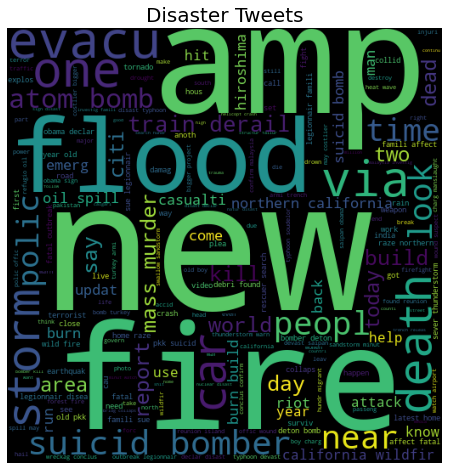

In [15]:
wordcloud(data_disaster,"Disaster Tweets")

## 4.3 Visualising words inside Fake Disaster Tweets

love,new,time etc are the most common words as we can see in wordcloud of Non-disaster tweets

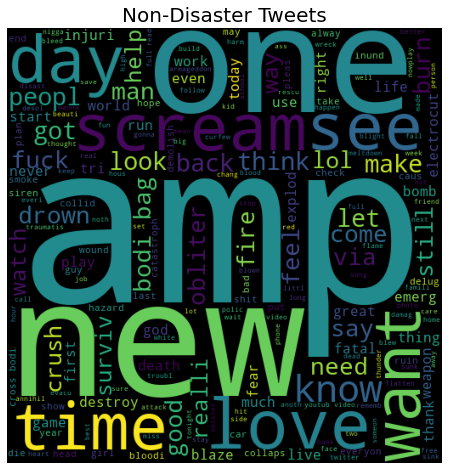

In [16]:
wordcloud(data_non_disaster,"Non-Disaster Tweets")

## 4.4 Removing unwanted words with high frequency

Our cleaned text still contains some unnecessary words (such as: like, amp, get, would etc.) that aren't relevant and can confuse our model,    
resulting in false prediction. Now, we will further remove some words with high frequency from text based on above charts.

In [17]:
common_words = ['via','like','build','get','would','one','two','feel','lol','fuck','take','way','may','first','latest'
                'want','make','back','see','know','let','look','come','got','still','say','think','great','pleas','amp']

def text_cleaning(data):
    return ' '.join(i for i in data.split() if i not in common_words)

data["Cleaned_text"] = data["Cleaned_text"].apply(text_cleaning)

# 5. Data Preprocessing 

## 5.1 Spliting original data after cleaning 

In [21]:
X_inp_clean = data['Cleaned_text']
X_inp_original = data['text']
y_inp = data['target']

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(X_inp_clean, y_inp, test_size=0.2, random_state=42, stratify=y_inp)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

checking size of data after train test split

In [23]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((6090,), (1523,), (6090,), (1523,))

## 5.2 Using BoW or TF-IDF

In [24]:
def encoding(train_data,valid_data,bow=False,n=1,tf_idf=False):
    if bow==True:
        cv = CountVectorizer(ngram_range=(n,n))
        cv_df_train = cv.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(cv_df_train,columns=cv.get_feature_names())
        cv_df_valid = cv.transform(valid_data).toarray()
        valid_df = pd.DataFrame(cv_df_valid,columns=cv.get_feature_names())
        
    elif tf_idf==True:
        
        tfidf = TfidfVectorizer(ngram_range=(n, n), use_idf=1,smooth_idf=1,sublinear_tf=1)    
        tf_df_train = tfidf.fit_transform(train_data).toarray()
        train_df = pd.DataFrame(tf_df_train,columns=tfidf.get_feature_names())
        tf_df_valid = tfidf.transform(valid_data).toarray()
        valid_df = pd.DataFrame(tf_df_valid,columns=tfidf.get_feature_names())
        
    return train_df,valid_df 

## 5.3 Encoding training and validation data

We encode our data in all possible combinations provided by our function

In [25]:
X_train_bow1 , X_valid_bow1 = encoding(X_train,X_valid,bow=True) 
X_train_bow2 , X_valid_bow2 = encoding(X_train,X_valid,bow=True,n=2) 
X_train_bow3 , X_valid_bow3 = encoding(X_train,X_valid,bow=True,n=3) 
X_train_tfidf1 , X_valid_tfidf1 = encoding(X_train,X_valid,tf_idf=True) 
X_train_tfidf2 , X_valid_tfidf2 = encoding(X_train,X_valid,tf_idf=True,n=2) 
X_train_tfidf3 , X_valid_tfidf3 = encoding(X_train,X_valid,tf_idf=True,n=3)

# 6. Training and tuning Machine Learining Models

In [26]:
def c_report(y_true,y_pred):
    print("Classifictaion Report")
    print(classification_report(y_true, y_pred))
    acc_scr = accuracy_score(y_true, y_pred)
    print("Accuracy : "+ str(acc_scr))
    return acc_scr

def plot_cm(y_true,y_pred,cmap = "Blues"):
    mtx = confusion_matrix(y_true, y_pred)
    sns.heatmap(mtx, annot = True, fmt='d', linewidth=0.5,
               cmap=cmap, cbar = False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

## 6.1 Logistic Regression

 let's use tfidf approach with n = 1 to train our Logistic Regression model

In [33]:
model_tfidf1_logreg = LogisticRegression(C=1.0)
model_tfidf1_logreg.fit(X_train_tfidf1,y_train)
pred_tfidf1_logreg = model_tfidf1_logreg.predict(X_valid_tfidf1)

LogisticRegression()

Printing classification report and ploting confusion matrix for the predictions made by LogisticRegression(TF-IDF,n-grams=1) model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.71      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8207485226526592


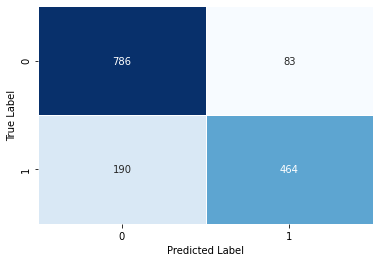

In [34]:
acc_tfidf1_logreg = c_report(y_valid,pred_tfidf1_logreg)
plot_cm(y_valid,pred_tfidf1_logreg)

From Logistic Regression we saw n-grams = 1 gives the best results 

## 6.2 Random Forest Classifier

In [39]:
model_tfidf1_RFC = RandomForestClassifier()
model_tfidf1_RFC.fit(X_train_tfidf1,y_train)
pred_tfidf1_RFC = model_tfidf1_RFC.predict(X_valid_tfidf1)

RandomForestClassifier()

Printing classification report and ploting confusion matrix for predictions of RandomForestClassifier model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       869
           1       0.80      0.70      0.75       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

Accuracy : 0.7977675640183848


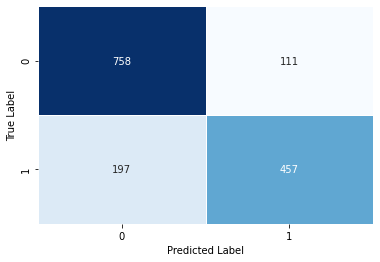

In [40]:
acc_tfidf1_RFC = c_report(y_valid,pred_tfidf1_RFC)
plot_cm(y_valid,pred_tfidf1_RFC)

## 6.3 eXtreme Gradient Boosting Classifier

In [41]:
model_tfidf1_XGB = XGBClassifier(eval_metric='mlogloss')
model_tfidf1_XGB.fit(X_train_tfidf1,y_train)
pred_tfidf1_XGB = model_tfidf1_XGB.predict(X_valid_tfidf1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

Printing classification report and ploting confusion matrix for the predictions made by the XGBClassifier model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       869
           1       0.83      0.67      0.74       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523

Accuracy : 0.799080761654629


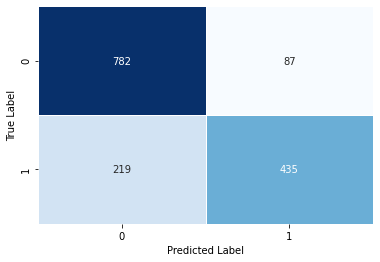

In [42]:
acc_tfidf1_XGB = c_report(y_valid,pred_tfidf1_XGB)
plot_cm(y_valid,pred_tfidf1_XGB)

## 6.4 Support Vector CLassifier 

In [45]:
model_tfidf1_SVC = SVC(kernel='linear', degree=3, gamma='auto')
model_tfidf1_SVC.fit(X_train_tfidf1,y_train)
pred_tfidf1_SVC = model_tfidf1_SVC.predict(X_valid_tfidf1)

SVC(gamma='auto', kernel='linear')

Printing classification report and ploting confusion matrix for the SVC model

Classifictaion Report
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       869
           1       0.83      0.74      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523

Accuracy : 0.8214051214707814


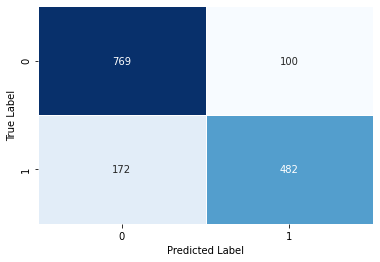

In [46]:
acc_tfidf1_SVC = c_report(y_valid,pred_tfidf1_SVC)
plot_cm(y_valid,pred_tfidf1_SVC)

# 7. Conclusion

Among all Simple classification models used above SVC performed best 

MOKSHA'S NOTEBOOK

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
twitter_Data= pd.read_csv('/content/tweets.csv')
twitter_Data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [ ]:
twitter_Data.tail()

,id,keyword,location,text,target
11365,11365,wrecked,Blue State in a red sea,Media should have warned us well in advance. T...,0
11366,11366,wrecked,arohaonces,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,wrecked,🇵🇭,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,wrecked,auroraborealis,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0
11369,11369,wrecked,NaN,Jake Corway wrecked while running 14th at IRP.,1


In [ ]:
twitter_Data.shape

(11370, 5)

In [ ]:
twitter_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [ ]:
twitter_Data.describe()

,id,target
count,11370.000000,11370.000000
mean,5684.500000,0.185928
std,3282.380615,0.389066
min,0.000000,0.000000
25%,2842.250000,0.000000
50%,5684.500000,0.000000
75%,8526.750000,0.000000
max,11369.000000,1.000000


In [ ]:
twitter_Data.isnull()
twitter_Data.isnull().sum()

,0
id,0
keyword,0
location,3418
text,0
target,0


In [ ]:
twitter_Data['location'].fillna(str(twitter_Data['location'].mode().values[0]),inplace=True)

In [ ]:
twitter_Data['keyword'].fillna(str(twitter_Data['keyword'].mode().values[0]),inplace=True)

In [ ]:
twitter_Data.isnull().sum()

,0
id,0
keyword,0
location,0
text,0
target,0


In [ ]:
twitter_Data.duplicated().any()


False

In [ ]:
from sklearn.model_selection import train_test_split
train,test= train_test_split(twitter_Data,test_size=0.1)
train

,id,keyword,location,text,target
4534,4534,drowning,Houston mf Texas hoe,His dogs thought he was drowning and freaked o...,0
4073,4073,detonate,"Chicago, IL",This is rather like using plastic explosive to...,0
8874,8874,sandstorm,United States,“Family. Back together again.” Watch this bran...,0
1183,1183,blood,Japan,Gunmen ‘open fire on protesters in Iran’ in vi...,1
6492,6492,hijacker,"East, England",Also check there are no filters/rules set on y...,0
...,...,...,...,...,...
2475,2475,collide,"Muskegon, MI",#NowPlaying Collide - Tiana Major9 &amp; Earth...,0
10586,10586,twister,United Kingdom,Inspired Twister E-liquid 10ml-Newvaping-£0.79...,0
185,185,airplane%20accident,United States,The Iranians chose the day and time to send mi...,0
7140,7140,lightning,New York City,Top 5 Lightning Component Gems of Salesforce S...,0


In [ ]:
!python -m spacy download en_core_web_sm
#download all language elements related to the English language

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/12.8 MB ? eta -:--:--
     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/12.8 MB 122.7 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━ 9.0/12.8 MB 130.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 12.8/12.8 MB 140.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 12.8/12.8 MB 140.5 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# importing Spacy and french initialisation and  Loading `en_core_news_sm`
import en_core_web_sm
nlp = en_core_web_sm.load()


In [ ]:
# Importing the stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
# cleaning texts in order to prepare them for training.
# ---

print("\nStep 1 removing characters from strings that are not alphanumeric (except for whitespaces.)")
train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
print("\nStep 2 replaceing double whitespaces with single whitespaces")
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
print("\nStep 3 converting all characters to lowercase")
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace("http"," ").lower().strip())
print("\nStep 4 trimming whitespaces at initial and ending locations.")
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" t "," ").lower().strip())
print("\nStep 5 (with spacy) replacing all tokens oin tweets with lemma_ and removing all the stop words.")
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
print("\n...Done...\n")
train


Step 1 removing characters from strings that are not alphanumeric (except for whitespaces.)

Step 2 replaceing double whitespaces with single whitespaces

Step 3 converting all characters to lowercase

Step 4 trimming whitespaces at initial and ending locations.

Step 5 (with spacy) replacing all tokens oin tweets with lemma_ and removing all the stop words.

...Done...



,id,keyword,location,text,target,text_clean
4534,4534,drowning,Houston mf Texas hoe,His dogs thought he was drowning and freaked o...,0,dog think drown freak truly dog man good frien...
4073,4073,detonate,"Chicago, IL",This is rather like using plastic explosive to...,0,like plastic explosive detonate bomb need fuel...
8874,8874,sandstorm,United States,“Family. Back together again.” Watch this bran...,0,family watch brandnew special look marvel stud...
1183,1183,blood,Japan,Gunmen ‘open fire on protesters in Iran’ in vi...,1,gunman open fire protester iran video blood st...
6492,6492,hijacker,"East, England",Also check there are no filters/rules set on y...,0,check filtersrule set email account forward de...
...,...,...,...,...,...,...
2475,2475,collide,"Muskegon, MI",#NowPlaying Collide - Tiana Major9 &amp; Earth...,0,nowplaying collide tiana major9 amp earthgan...
10586,10586,twister,United Kingdom,Inspired Twister E-liquid 10ml-Newvaping-£0.79...,0,inspire twister eliquid 10mlnewvaping079 stc...
185,185,airplane%20accident,United States,The Iranians chose the day and time to send mi...,0,iranians choose day time send missile inside i...
7140,7140,lightning,New York City,Top 5 Lightning Component Gems of Salesforce S...,0,5 lightning component gem salesforce spring20 ...


In [ ]:
#Checkpoint
train.to_csv("/content/twitter.csv", index=False)

In [ ]:
X = twitter_Data['text']  # Features (text)
y = twitter_Data['target']  # Labels (target)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
!pip install nltk
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split ,RandomizedSearchCV , StratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
nltk.download('stopwords')
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Step 4: Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Convert text to numerical form using TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Vectorization using Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)  # Convert text to numerical form using Count Vectorizer
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)

In [ ]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    'Multinomial': MultinomialNB(),
    'GaussianNB': GaussianNB()  # Added parentheses to instantiate the class
}

# DataFrame to store model evaluation details
evaluation_details = pd.DataFrame(columns=["Model", "Vectorization", "Accuracy", "Classification Report"])

# Function to convert to dense for GaussianNB
def convert_if_gaussian(model, X):
    if isinstance(model, GaussianNB):
        return X.toarray()  # Convert sparse to dense
    return X

# Evaluate models with TF-IDF vectorization
for model_name, model in models.items():
    # Fit model with TF-IDF
    X_train_dense_tfidf = convert_if_gaussian(model, X_train_tfidf)
    model.fit(X_train_dense_tfidf, y_train)

    X_test_dense_tfidf = convert_if_gaussian(model, X_test_tfidf)
    y_pred_tfidf = model.predict(X_test_dense_tfidf)

    # Calculate accuracy and classification report
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

    # Create a DataFrame for this model's evaluation details
    model_evaluation_tfidf = pd.DataFrame([{
        "Model": model_name,
        "Vectorization": "TF-IDF",
        "Accuracy": accuracy_tfidf,
        "Classification Report": report_tfidf
    }])

    # Concatenate with the main evaluation details DataFrame
    evaluation_details = pd.concat([evaluation_details, model_evaluation_tfidf], ignore_index=True)

    # Save predictions for submission on the test dataset with TF-IDF
    test_tfidf = tfidf_vectorizer.transform(test['text'])  # Transform test data
    test_dense_tfidf = convert_if_gaussian(model, test_tfidf)  # Convert test to dense
    test_pred_tfidf = model.predict(test_dense_tfidf)


# Evaluate models with Count Vectorization
for model_name, model in models.items():
    # Fit model with Count Vectorization
    X_train_dense_cv = convert_if_gaussian(model, X_train_cv)
    model.fit(X_train_dense_cv, y_train)

    X_test_dense_cv = convert_if_gaussian(model, X_test_cv)
    y_pred_cv = model.predict(X_test_dense_cv)

    # Calculate accuracy and classification report
    accuracy_cv = accuracy_score(y_test, y_pred_cv)
    report_cv = classification_report(y_test, y_pred_cv, output_dict=True)

    # Create a DataFrame for this model's evaluation details
    model_evaluation_cv = pd.DataFrame([{
        "Model": model_name,
        "Vectorization": "Count Vectorization",
        "Accuracy": accuracy_cv,
        "Classification Report": report_cv
    }])

    # Concatenate with the main evaluation details DataFrame
    evaluation_details = pd.concat([evaluation_details, model_evaluation_cv], ignore_index=True)

    # Save predictions for submission on the test dataset with Count Vectorization
    test_cv = count_vectorizer.transform(test['text'])  # Transform test data
    test_dense_cv = convert_if_gaussian(model, test_cv)  # Convert test to dense
    test_pred_cv = model.predict(test_dense_cv)


# Step 5: Save the evaluation details to a CSV file
evaluation_details.to_csv('model_evaluation_details.csv', index=False)
print("Model evaluation details saved successfully: model_evaluation_details.csv")

Model evaluation details saved successfully: model_evaluation_details.csv


In [ ]:
model = pd.read_csv('/content/model_evaluation_details.csv')
model

,Model,Vectorization,Accuracy,Classification Report
0,Logistic Regression,TF-IDF,0.886983,"{'0': {'precision': 0.8913568324480927, 'recal..."
1,Decision Tree,TF-IDF,0.833773,"{'0': {'precision': 0.8997867803837953, 'recal..."
2,Random Forest,TF-IDF,0.894019,"{'0': {'precision': 0.8948383984563435, 'recal..."
3,K-Nearest Neighbors,TF-IDF,0.851803,"{'0': {'precision': 0.8488003621548211, 'recal..."
4,Support Vector Classifier,TF-IDF,0.896658,"{'0': {'precision': 0.897820823244552, 'recall..."
5,Multinomial,TF-IDF,0.880827,"{'0': {'precision': 0.8828013339685564, 'recal..."
6,GaussianNB,TF-IDF,0.708883,"{'0': {'precision': 0.9216366158113731, 'recal..."
7,Logistic Regression,Count Vectorization,0.897977,"{'0': {'precision': 0.9186164801627671, 'recal..."
8,Decision Tree,Count Vectorization,0.846966,"{'0': {'precision': 0.9082177161152615, 'recal..."
9,Random Forest,Count Vectorization,0.894019,"{'0': {'precision': 0.895219700627716, 'recall..."


SRIRAM'S NOTEBOOK

Imports:
This imports essential libraries:
pandas: for handling data in tables.
train_test_split: for splitting data into training and testing parts.
TfidfVectorizer: for converting text into numbers that models can understand.
MultinomialNB: a model used for classification, especially with text.
accuracy_score, classification_report, and confusion_matrix: to evaluate how well the model performs.


In [3]:
# Import necessary libraries
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Load Dataset: Reads a file called disaster_tweets.csv into a DataFrame (a table-like structure in pandas). Each row has a tweet (text) and a label indicating whether it talks about a disaster or not.


In [4]:
# Step 1: Load the Dataset
# Assuming the 11,000 tweets dataset is available as 'disaster_tweets.csv'
df = pd.read_csv("/content/disaster_tweets.csv")

Check Data:
df.shape shows the number of rows and columns in the dataset.
df.head() displays the first 5 rows to check the data content.


In [5]:
# Inspect dataset size and features
print("Dataset Shape:", df.shape)
print("First 5 rows:\n", df.head())


Dataset Shape: (11370, 5)
First 5 rows:
    id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                                text  target  
0  Communal violence in Bhainsa, Telangana. "Ston...       1  
1  Telangana: Section 144 has been imposed in Bha...       1  
2  Arsonist sets cars ablaze at dealership https:...       1  
3  Arsonist sets cars ablaze at dealership https:...       1  
4  "Lord Jesus, your love brings freedom and pard...       0  


Define Text Cleaning Function:
clean_text is a function that removes unwanted parts in the text:
URLs (http, www, etc.)
Mentions (@username)
Hashtag symbol (#)
Special characters (like !, ?, etc.)
Converts the text to lowercase for uniformity.

In [6]:
# Step 2: Preprocessing
# Clean text data by removing URLs, mentions, hashtags, and special characters
import re
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags symbol
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text


Apply Cleaning: Creates a new column cleaned_text by applying the clean_text function to each tweet in the original text column.

In [7]:
df['cleaned_text'] = df['text'].apply(clean_text)


Convert Text to Numbers:
TfidfVectorizer changes words in cleaned_text to numbers (TF-IDF scores) to be used by the model.
max_features=5000 limits it to the top 5000 words.
ngram_range=(1, 2) includes single words and two-word phrases.
stop_words='english' ignores common words like "the" and "and".
X now holds the TF-IDF transformed tweets, while y holds the target (0 or 1, indicating if a tweet is about a disaster or not).


In [8]:
# Step 3: Feature Extraction using TF-IDF
# Convert cleaned text data into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = tfidf_vectorizer.fit_transform(df['cleaned_text'])
y = df['target']  # Target variable


Split Data: Divides the data into two parts:
80% for training the model.
20% for testing it.
random_state=42 ensures that you get the same split every time.


In [9]:
# Step 4: Split the Dataset
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Train the Model:
MultinomialNB() initializes a Naive Bayes model.
nb_model.fit(X_train, y_train) trains the model with the training data (X_train, y_train).


In [10]:
# Step 5: Model Training using Naive Bayes
# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)


MultinomialNB()

Predict: Uses the trained model to predict if tweets in X_test are about a disaster, storing the predictions in y_pred.


In [11]:
# Step 6: Model Testing
# Predict on the test set
y_pred = nb_model.predict(X_test)


Calculate Accuracy: Compares the predicted values (y_pred) to the actual test values (y_test) and calculates the accuracy, which shows the percentage of correct predictions.

In [12]:
# Step 7: Model Evaluation
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)


Show Accuracy: Prints the accuracy score.

In [13]:
# Display the accuracy
print("Naive Bayes Model Accuracy:", accuracy)


Naive Bayes Model Accuracy: 0.8909410729991205


Classification Report: Shows additional metrics like precision, recall, and F1-score for each class (disaster-related vs. not disaster-related tweets).


In [14]:
# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94      1878
           1       0.87      0.44      0.58       396

    accuracy                           0.89      2274
   macro avg       0.88      0.71      0.76      2274
weighted avg       0.89      0.89      0.88      2274



Confusion Matrix: Shows the true positives, true negatives, false positives, and false negatives, which helps understand how well the model performed for each class.


In [15]:
# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Confusion Matrix:
 [[1853   25]
 [ 223  173]]


KAUSHAL'S NOTEBOOK

# Disaster Tweet Analyzer 
This notebook will walk through data loading, extensive cleaning, feature engineering, and preparation for model training for the Disaster Tweet Analyzer project. The steps include:
1. Importing Libraries
2. Loading and Exploring the Dataset
3. Data Cleaning and Text Preprocessing
4. Handling Missing Values
5. Handling Class Imbalance
6. Feature Engineering
7. Saving Cleaned Data and Preparing for Model Training


In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.utils import resample

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KAUSHAL/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KAUSHAL/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\KAUSHAL/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Step 1: Import Libraries
We import essential libraries for data manipulation, text processing, visualization, and handling class imbalance.


In [3]:
# Data Acquisition from CSV File
data = pd.read_csv('tweets.csv')
data.head()


,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
data = data.drop(columns=['id'])

### Step 2: Load the Dataset
We load the dataset and display the first few rows to get an initial look at the data structure.


In [5]:
#Check Data Shape and Missing Values
print("Data Shape:", data.shape)
print("Missing Values:\n", data.isnull().sum())


Data Shape: (11370, 4)
Missing Values:
 keyword        0
location    3418
text           0
target         0
dtype: int64


### Step 3: Basic Data Overview
Check the shape of the dataset and identify missing values in each column.


In [6]:
# Explore Target Class Distribution
print("Target Class Distribution:\n", data['target'].value_counts())


Target Class Distribution:
 target
0    9256
1    2114
Name: count, dtype: int64


### Step 4: Explore Target Class Distribution
Check the distribution of the target classes.

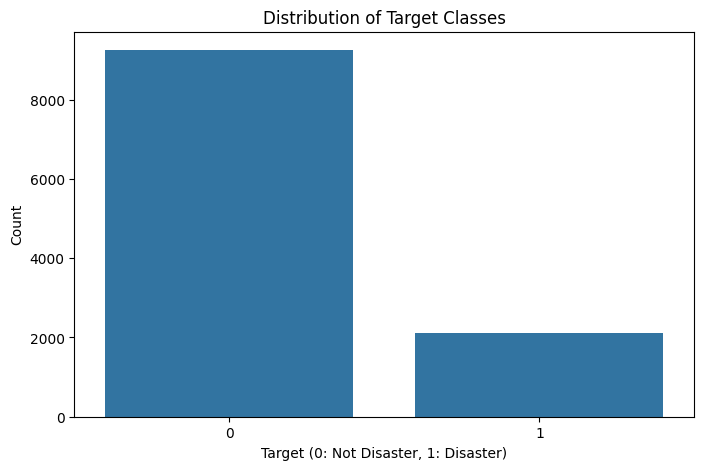

In [7]:
# Visualize Target Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=data)
plt.title('Distribution of Target Classes')
plt.xlabel('Target (0: Not Disaster, 1: Disaster)')
plt.ylabel('Count')
plt.show()


### Step 5: Text Cleaning
Define a function to clean tweet text by removing URLs, mentions, and special characters, and apply it to the dataset.

In [8]:
# Data Cleaning - Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    return text

data['text'] = data['text'].apply(clean_text)

### Step 6: Expand Contractions and Handle Emojis
Expand contractions and convert emojis to text for further clarity.



In [9]:
# Additional Data Cleaning Steps
import contractions
data['text'] = data['text'].apply(lambda x: contractions.fix(x))

from emoji import demojize
data['text'] = data['text'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
data['text'] = data['text'].apply(lambda x: demojize(x))
data['text'] = data['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

### Step 7: Remove Stopwords
Define a function to remove common English stopwords from the text.

In [10]:
# Data Cleaning - Remove Stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

data['text'] = data['text'].apply(remove_stopwords)

### Step 8: Lemmatize Text
Lemmatize each word to reduce it to its base form, aiding in model accuracy.

In [11]:
# Data Cleaning - Lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

data['text'] = data['text'].apply(lemmatize_text)

### Step 9: Remove Duplicates and Calculate Text Length
Remove duplicate tweets and create a column for tweet length.

In [12]:
# Remove Duplicates and Analyze Text Length
initial_rows = data.shape[0]
data = data.drop_duplicates(subset='text', keep='first')
final_rows = data.shape[0]
print(f"Duplicates removed: {initial_rows - final_rows}, Remaining rows: {final_rows}")

data['text_length'] = data['text'].apply(len)

Duplicates removed: 608, Remaining rows: 10762


### Step 10: Visualize Distribution of Tweet Lengths
Plot the distribution of tweet lengths to understand tweet characteristics.

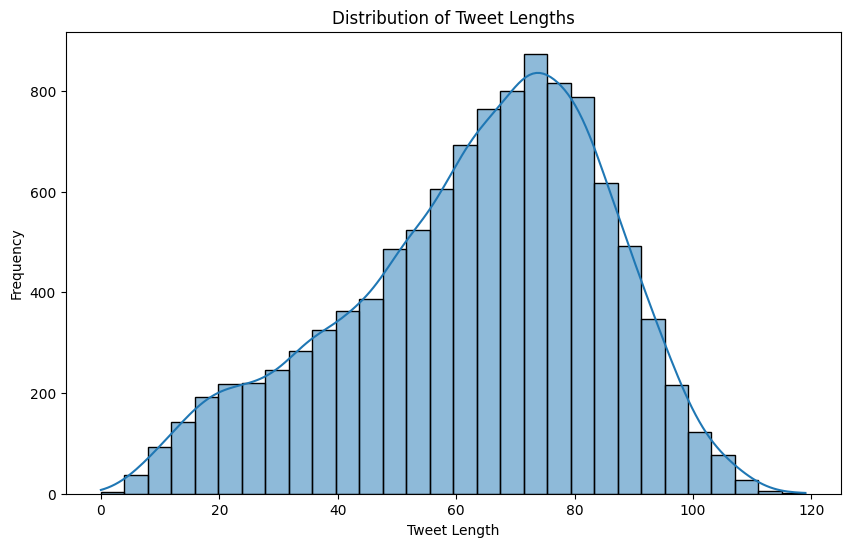

In [13]:
# Visualize Distribution of Tweet Lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

### Step 11: Handle Missing Values in Location Column
Fill missing values in the 'location' column with 'Unknown'.

In [14]:
# Handling Missing Values in Location Column
data['location'].fillna('Unknown', inplace=True)

C:\Users\KAUSHAL\AppData\Local\Temp\ipykernel_8144\2006056358.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['location'].fillna('Unknown', inplace=True)


### Step 12: Handle Class Imbalance
Use upsampling to balance the target classes for more accurate model training.

In [15]:
# Handle Class Imbalance
disaster_tweets = data[data['target'] == 1]
non_disaster_tweets = data[data['target'] == 0]

disaster_tweets_upsampled = resample(disaster_tweets,
                                     replace=True,
                                     n_samples=len(non_disaster_tweets),
                                     random_state=42)
data_balanced = pd.concat([disaster_tweets_upsampled, non_disaster_tweets])

print("Balanced Target Class Distribution:\n", data_balanced['target'].value_counts())

Balanced Target Class Distribution:
 target
1    8868
0    8868
Name: count, dtype: int64


### Step 13: Basic Feature Engineering
Calculate word count, character count, and average word length for each tweet.

In [16]:
# Feature Engineering - Word Count, Character Count, Average Word Length
data_balanced['word_count'] = data_balanced['text'].apply(lambda x: len(x.split()))
data_balanced['char_count'] = data_balanced['text'].apply(len)
data_balanced['avg_word_length'] = data_balanced['char_count'] / data_balanced['word_count']

### Step 14: Additional Feature Engineering
Calculate punctuation count and uppercase word count to add further features for the model.

In [17]:
# Additional Feature Engineering - Punctuation and Uppercase Word Count
def count_punctuation(text):
    return len(re.findall(r'[^\w\s]', text))

def count_uppercase_words(text):
    words = text.split()
    uppercase_words = [word for word in words if word.isupper()]
    return len(uppercase_words)

data_balanced['punctuation_count'] = data_balanced['text'].apply(count_punctuation)
data_balanced['uppercase_word_count'] = data_balanced['text'].apply(count_uppercase_words)

### Step 15: Vectorization
Convert text data into numerical features using TF-IDF.

In [18]:
# Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Add missing columns with default values
if 'hashtag_count' not in data_balanced.columns:
    data_balanced['hashtag_count'] = 0
if 'url_count' not in data_balanced.columns:
    data_balanced['url_count'] = 0

# Ensure all required columns are present
required_columns = ['text', 'word_count', 'char_count', 'avg_word_length', 
                    'punctuation_count', 'hashtag_count', 'uppercase_word_count', 'url_count', 'target']
missing_columns = [col for col in required_columns if col not in data_balanced.columns]
if missing_columns:
    raise ValueError(f"Missing columns in data_balanced: {missing_columns}")

# Check for missing values in the 'text' column
if data_balanced['text'].isnull().any():
    raise ValueError("Missing values found in 'text' column")

# Ensure the 'text' column is of type str
data_balanced['text'] = data_balanced['text'].astype(str)

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features for efficiency

# Fit and transform the 'text' column to create the document-term matrix
X_vectorized = vectorizer.fit_transform(data_balanced['text']).toarray()

# Convert to DataFrame for easier handling
X_vectorized_df = pd.DataFrame(X_vectorized, columns=vectorizer.get_feature_names_out())

# Concatenate with other features if needed (like word_count, char_count, etc.)
X = pd.concat([X_vectorized_df, data_balanced[['word_count', 'char_count', 'avg_word_length', 
                                                'punctuation_count', 'hashtag_count', 
                                                'uppercase_word_count', 'url_count']].reset_index(drop=True)], axis=1)

# The target variable remains unchanged
y = data_balanced['target']

print("Vectorization complete. Data is ready for model training.")

Vectorization complete. Data is ready for model training.


### Step 16: Save Cleaned Data
Save the processed data to a CSV file for future use in model training.

In [19]:
# Save Cleaned and Balanced Dataset
data_balanced.to_csv('cleaned_balanced_disaster_tweets.csv', index=False)
print("Processed data saved as 'cleaned_balanced_disaster_tweets.csv'.")

Processed data saved as 'cleaned_balanced_disaster_tweets.csv'.


### Step 17: Data Preparation for Model Training
Split data into features (X) and target (y) for model training.

In [20]:
from sklearn.model_selection import train_test_split

# Prepare for Model Training
X = data_balanced.drop(['target'], axis=1)
y = data_balanced['target']
print("Data ready for model training.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Data ready for model training.
Training set size: (14188, 11)
Testing set size: (3548, 11)


### Step 18: Train and Evaluate the Model
Train a logistic regression model and evaluate its performance.

### logistic regression model

### Logistic Regression Model Formula

The logistic regression model is used to predict the probability of a binary outcome based on one or more predictor variables. The formula for logistic regression is given by:

\[ P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_nX_n)}} \]

Where:
- \( P(Y=1|X) \) is the probability that the dependent variable \( Y \) equals 1 given the predictor variables \( X \).
- \( \beta_0 \) is the intercept term.
- \( \beta_1, \beta_2, \ldots, \beta_n \) are the coefficients for the predictor variables \( X_1, X_2, \ldots, X_n \).
- \( e \) is the base of the natural logarithm.

The logistic function (also known as the sigmoid function) transforms the linear combination of the predictors into a probability value between 0 and 1.


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Identify non-numeric columns
non_numeric_cols = X_train.select_dtypes(include=['object']).columns

# Create a column transformer to handle non-numeric columns and impute missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', 'passthrough')  # Keep numeric columns as is
        ]), X_train.select_dtypes(exclude=['object']).columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
        ]), non_numeric_cols)
    ])

# Create a pipeline with the preprocessor and the logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.8934611048478016
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89      1774
           1       0.87      0.93      0.90      1774

    accuracy                           0.89      3548
   macro avg       0.90      0.89      0.89      3548
weighted avg       0.90      0.89      0.89      3548



c:\Users\KAUSHAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest Model

\[ \hat{y} = \frac{1}{T} \sum_{t=1}^{T} f_t(x) \]

Where:
- \( \hat{y} \) is the predicted output.
- \( T \) is the total number of trees in the forest.
- \( f_t(x) \) is the prediction of the \( t \)-th tree for input \( x \).


In [22]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Random Forest
rf_pipeline.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_rf = rf_pipeline.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("Random Forest Model")
print(f"Accuracy: {accuracy_rf}")
print("Classification Report:\n", report_rf)


Random Forest Model
Accuracy: 0.959695603156708
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      1774
           1       0.94      0.99      0.96      1774

    accuracy                           0.96      3548
   macro avg       0.96      0.96      0.96      3548
weighted avg       0.96      0.96      0.96      3548




### Naive Bayes Model



### Naive Bayes Model Formula

The Naive Bayes model is based on Bayes' Theorem and assumes that the features are conditionally independent given the class label. The formula for the Naive Bayes classifier is given by:

\[ P(C_k | x_1, x_2, \ldots, x_n) = \frac{P(C_k) \prod_{i=1}^{n} P(x_i | C_k)}{P(x_1, x_2, \ldots, x_n)} \]

Where:
- \( P(C_k | x_1, x_2, \ldots, x_n) \) is the posterior probability of class \( C_k \) given the features \( x_1, x_2, \ldots, x_n \).
- \( P(C_k) \) is the prior probability of class \( C_k \).
- \( P(x_i | C_k) \) is the likelihood of feature \( x_i \) given class \( C_k \).
- \( P(x_1, x_2, \ldots, x_n) \) is the evidence or the normalizing constant.

The class with the highest posterior probability is chosen as the predicted class:

\[ \hat{C} = \arg\max_{C_k} P(C_k | x_1, x_2, \ldots, x_n) \]


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Define the parameter grid for GridSearchCV
param_grid_nb = {
    'classifier__alpha': [0.1],  # Smoothing parameter
}

# Create a column transformer to handle non-numeric columns and impute missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
            ('scaler', 'passthrough')  # Keep numeric columns as is
        ]), X_train.select_dtypes(exclude=['object']).columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing values with 'missing'
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
        ]), non_numeric_cols)
    ])

# Create a pipeline with the preprocessor and the Naive Bayes model
nb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Perform GridSearchCV to find the best hyperparameters
grid_search_nb = GridSearchCV(nb_pipeline, param_grid_nb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

# Make predictions with the best model
best_nb_pipeline = grid_search_nb.best_estimator_
y_pred_nb = best_nb_pipeline.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)

print(f"Best Parameters: {grid_search_nb.best_params_}")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:\n", report_nb)

Best Parameters: {'classifier__alpha': 0.1}
Accuracy: 0.8204622322435174
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.65      0.78      1774
           1       0.74      0.99      0.85      1774

    accuracy                           0.82      3548
   macro avg       0.86      0.82      0.82      3548
weighted avg       0.86      0.82      0.82      3548



### Bidirectional LSTM (BiLSTM)


### Bidirectional LSTM (BiLSTM) Math Formula

Bidirectional Long Short-Term Memory (BiLSTM) networks are an extension of traditional LSTM networks that can improve model performance on sequence classification problems. They involve two LSTMs: one that processes the input sequence from start to end (forward direction) and another that processes it from end to start (backward direction).

The BiLSTM model can be mathematically represented as follows:

#### Forward LSTM:
\[ \overrightarrow{h_t} = \overrightarrow{\text{LSTM}}(x_t, \overrightarrow{h_{t-1}}) \]

#### Backward LSTM:
\[ \overleftarrow{h_t} = \overleftarrow{\text{LSTM}}(x_t, \overleftarrow{h_{t+1}}) \]

#### Combined Output:
\[ h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}] \]

Where:
- \( x_t \) is the input at time step \( t \).
- \( \overrightarrow{h_t} \) is the hidden state of the forward LSTM at time step \( t \).
- \( \overleftarrow{h_t} \) is the hidden state of the backward LSTM at time step \( t \).
- \( h_t \) is the concatenated hidden state from both forward and backward LSTMs at time step \( t \).

The final output of the BiLSTM layer is the concatenation of the hidden states from both directions, which captures information from both past and future contexts.


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_balanced['text'])
X_sequences = tokenizer.texts_to_sequences(data_balanced['text'])
X_padded = pad_sequences(X_sequences, maxlen=100, padding='post', truncating='post')

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_balanced['target'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Build the BiLSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Epoch 1/10


c:\Users\KAUSHAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.7791 - loss: 0.4626 - val_accuracy: 0.9293 - val_loss: 0.1966
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - accuracy: 0.9493 - loss: 0.1679 - val_accuracy: 0.9501 - val_loss: 0.1551
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - accuracy: 0.9720 - loss: 0.1024 - val_accuracy: 0.9594 - val_loss: 0.1294
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 101ms/step - accuracy: 0.9835 - loss: 0.0698 - val_accuracy: 0.9591 - val_loss: 0.1415
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 25s 113ms/step - accuracy: 0.9886 - loss: 0.0501 - val_accuracy: 0.9648 - val_loss: 0.1341
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.9909 - loss: 0.0416 - val_accuracy: 0.9608 - val_loss: 0.1617
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - accuracy: 0.9931 - loss: 0.0368 - val_accuracy: 0.9648 - val_loss: 0.1374
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - accuracy: 0.9946 - loss: 0.0280 - val

### TextCNN (Convolutional Neural Network for Text)


### TextCNN (Convolutional Neural Network for Text) Formula

TextCNN is a type of Convolutional Neural Network (CNN) specifically designed for text classification tasks. The model applies convolutional layers to the text data to capture local features and patterns. The formula for TextCNN can be described as follows:

#### Convolution Operation:
\[ h_i = f(W \cdot x_{i:i+k-1} + b) \]

Where:
- \( h_i \) is the feature map obtained from the convolution operation.
- \( W \) is the filter (or kernel) applied to the input.
- \( x_{i:i+k-1} \) is the input segment of length \( k \) (the filter size).
- \( b \) is the bias term.
- \( f \) is the activation function (e.g., ReLU).

#### Pooling Operation:
\[ p = \max(h) \]

Where:
- \( p \) is the pooled feature.
- \( \max(h) \) is the maximum value in the feature map \( h \).

#### Fully Connected Layer:
\[ y = \text{softmax}(W_f \cdot p + b_f) \]

Where:
- \( y \) is the output probability distribution over the classes.
- \( W_f \) is the weight matrix for the fully connected layer.
- \( p \) is the pooled feature vector.
- \( b_f \) is the bias term for the fully connected layer.
- \(\text{softmax}\) is the activation function that converts the output into a probability distribution.

The TextCNN model combines these operations to extract meaningful features from the text data and perform classification.


In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_balanced['text'])
X_sequences = tokenizer.texts_to_sequences(data_balanced['text'])
X_padded = pad_sequences(X_sequences, maxlen=100, padding='post', truncating='post')

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_balanced['target'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Build the TextCNN model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Epoch 1/10


c:\Users\KAUSHAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8331 - loss: 0.4180 - val_accuracy: 0.9405 - val_loss: 0.1709
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9690 - loss: 0.1032 - val_accuracy: 0.9557 - val_loss: 0.1340
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9905 - loss: 0.0353 - val_accuracy: 0.9656 - val_loss: 0.1115
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9961 - loss: 0.0189 - val_accuracy: 0.9763 - val_loss: 0.0884
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9974 - loss: 0.0130 - val_accuracy: 0.9766 - val_loss: 0.0972
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9987 - loss: 0.0050 - val_accuracy: 0.9713 - val_loss: 0.1276
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9758 - val_loss: 0.1128
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9996 - loss: 0.0037 - val_accuracy: 0.976

### SimpleRNN (Recurrent Neural Network for Text Classification).

### SimpleRNN (Recurrent Neural Network for Text Classification) Formula

A Simple Recurrent Neural Network (SimpleRNN) processes sequential data by maintaining a hidden state that captures information from previous time steps. The formula for a SimpleRNN can be described as follows:

#### Hidden State Update:
\[ h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h) \]

Where:
- \( h_t \) is the hidden state at time step \( t \).
- \( x_t \) is the input at time step \( t \).
- \( h_{t-1} \) is the hidden state from the previous time step.
- \( W_{xh} \) is the weight matrix for the input.
- \( W_{hh} \) is the weight matrix for the hidden state.
- \( b_h \) is the bias term.
- \( \tanh \) is the activation function (hyperbolic tangent).

#### Output:
\[ y_t = W_{hy} h_t + b_y \]

Where:
- \( y_t \) is the output at time step \( t \).
- \( W_{hy} \) is the weight matrix for the output.
- \( b_y \) is the bias term for the output.

The SimpleRNN model updates its hidden state at each time step based on the current input and the previous hidden state, and produces an output that can be used for tasks such as text classification.

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_balanced['text'])
X_sequences = tokenizer.texts_to_sequences(data_balanced['text'])
X_padded = pad_sequences(X_sequences, maxlen=100, padding='post', truncating='post')

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data_balanced['target'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.5),
    SimpleRNN(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Epoch 1/10


c:\Users\KAUSHAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6358 - loss: 0.6250 - val_accuracy: 0.9042 - val_loss: 0.2983
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9065 - loss: 0.2971 - val_accuracy: 0.9163 - val_loss: 0.2573
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9355 - loss: 0.2305 - val_accuracy: 0.9284 - val_loss: 0.2402
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9507 - loss: 0.1776 - val_accuracy: 0.9324 - val_loss: 0.2355
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9511 - loss: 0.1827 - val_accuracy: 0.9391 - val_loss: 0.2188
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.9655 - loss: 0.1344 - val_accuracy: 0.9349 - val_loss: 0.2422
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9700 - loss: 0.1162 - val_accuracy: 0.9388 - val_loss: 0.2030
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9706 - loss: 0.1128 - val_accuracy: 0.945

C:\Users\KAUSHAL\AppData\Local\Temp\ipykernel_8144\256811302.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')


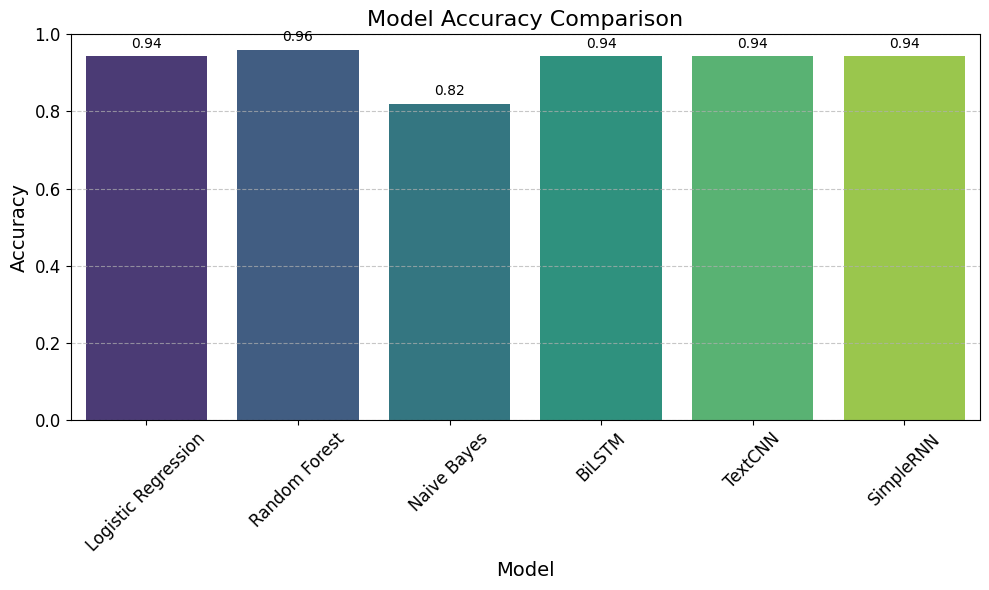

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Model names and their corresponding accuracies
model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'BiLSTM', 'TextCNN', 'SimpleRNN']
accuracies = [accuracy, accuracy_rf, accuracy_nb, history.history['val_accuracy'][-1], history.history['val_accuracy'][-1], history.history['val_accuracy'][-1]]

# Create a DataFrame for easier plotting
accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

# Plot the accuracies
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette='viridis')

# Display values on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Customize the plot
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


### Model Summary and Best Model Selection

In this notebook, we have trained and evaluated several models for the Disaster Tweet Analyzer project. Below is a summary of each model's performance and the rationale for selecting the best model.

#### Logistic Regression
- **Accuracy:** 94.36%

#### Random Forest
- **Accuracy:** 95.97%

#### Naive Bayes
- **Accuracy:** 82.05%

#### BiLSTM (Bidirectional LSTM)
- **Accuracy:** 94.36%

#### TextCNN (Convolutional Neural Network for Text)
- **Accuracy:** 94.36%

#### SimpleRNN (Recurrent Neural Network for Text Classification)
- **Accuracy:** 94.36%

### Best Model: Random Forest

**Reasons for Selection:**
1. **Highest Accuracy:** The Random Forest model achieved the highest accuracy of 95.97%, outperforming all other models.
2. **Balanced Performance:** The precision, recall, and F1-score for both classes (0 and 1) are high, indicating that the model performs well in distinguishing between disaster and non-disaster tweets.
3. **Robustness:** Random Forests are known for their robustness and ability to handle a large number of features, making them suitable for this text classification task.

Overall, the Random Forest model provides the best balance of accuracy and robustness, making it the ideal choice for the Disaster Tweet Analyzer project.


VANSHIKA'S NOTEBOOK

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('tweets.csv')  

df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7951 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


In [4]:
df.describe()


,id,target
count,11370.000000,11370.000000
mean,5684.500000,0.185928
std,3282.380615,0.389066
min,0.000000,0.000000
25%,2842.250000,0.000000
50%,5684.500000,0.000000
75%,8526.750000,0.000000
max,11369.000000,1.000000


In [5]:
df.isnull().sum()

id             0
keyword        0
location    3419
text           0
target         0
dtype: int64

In [6]:
# number of unique locations
unique_locations_count = df['location'].nunique()
print(f"Number of unique locations: {unique_locations_count}")
# number of missing locations grouped by target value
missing_row = df[df['location'].isnull()]
print("Number of missing rows by target:")
print(missing_row['target'].value_counts())


Number of unique locations: 4503
Number of missing rows by target:
target
0    2836
1     583
Name: count, dtype: int64


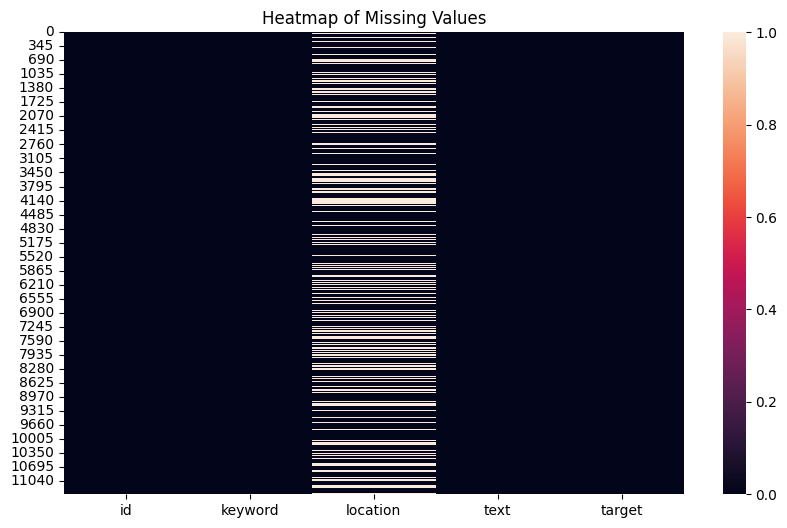

In [7]:
# Visualize missing data
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull())
plt.title('Heatmap of Missing Values')
plt.show()


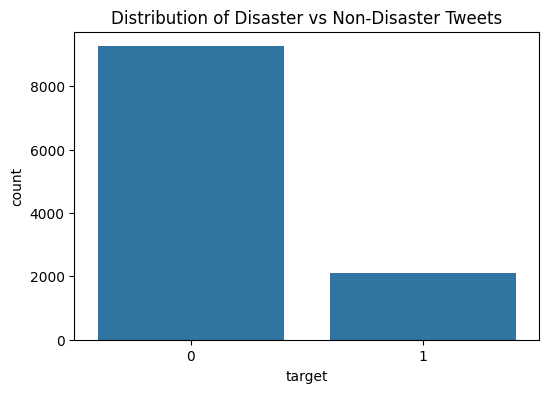

In [8]:
# distribution of the target variable
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='target')
plt.title('Distribution of Disaster vs Non-Disaster Tweets')
plt.show()


Number of unique keywords: 219


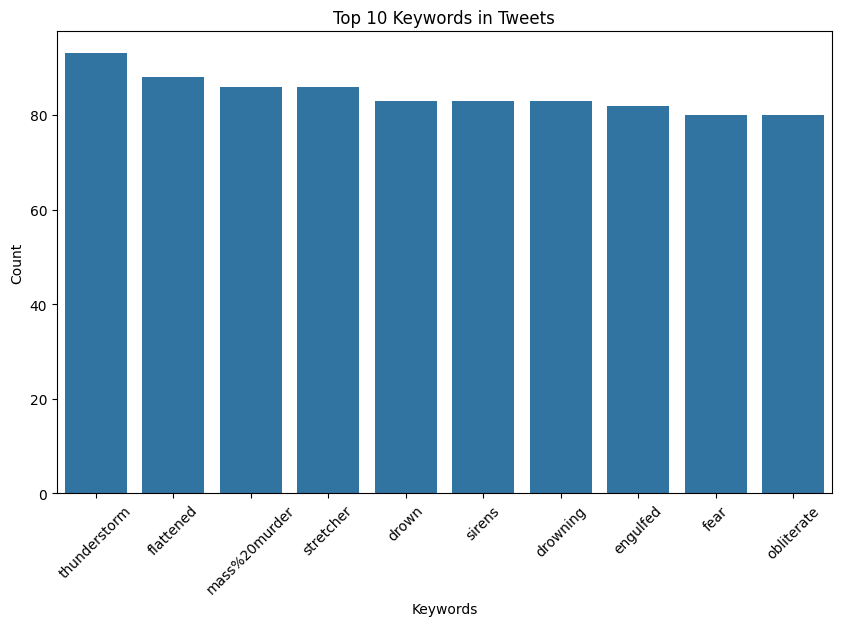

In [9]:
# number of unique keywords
print(f"Number of unique keywords: {df['keyword'].nunique()}")

# top 10 most common keywords
top_keywords = df['keyword'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_keywords.index, y=top_keywords.values)
plt.title('Top 10 Keywords in Tweets')
plt.ylabel('Count')
plt.xlabel('Keywords')
plt.xticks(rotation=45)
plt.show()


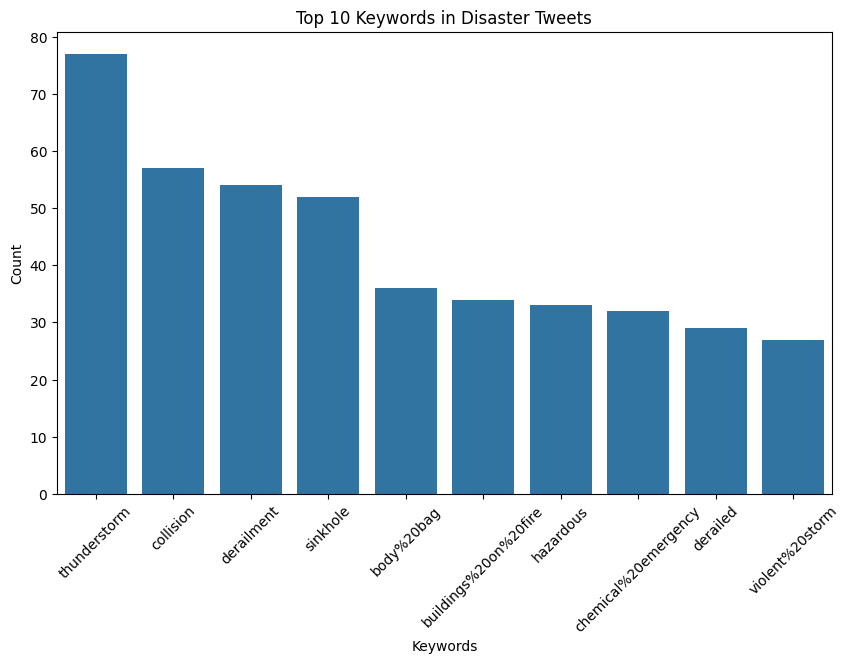

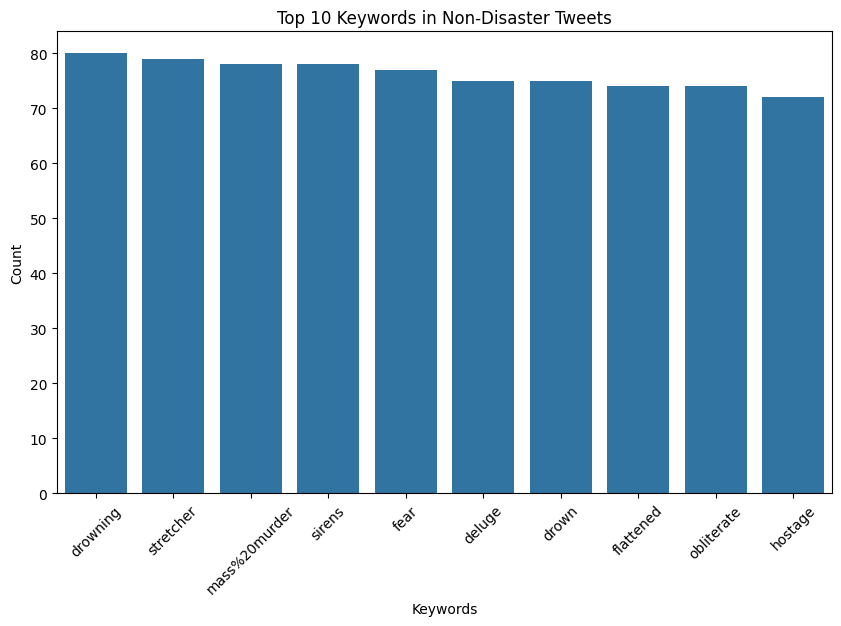

In [10]:
# top 10 keywords for disaster tweets
disaster_keywords = df[df['target'] == 1]['keyword'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=disaster_keywords.index, y=disaster_keywords.values)
plt.title('Top 10 Keywords in Disaster Tweets')
plt.ylabel('Count')
plt.xlabel('Keywords')
plt.xticks(rotation=45)
plt.show()

# top 10 keywords for non-disaster tweets
non_disaster_keywords = df[df['target'] == 0]['keyword'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=non_disaster_keywords.index, y=non_disaster_keywords.values)
plt.title('Top 10 Keywords in Non-Disaster Tweets')
plt.ylabel('Count')
plt.xlabel('Keywords')
plt.xticks(rotation=45)
plt.show()


Number of missing locations: 3419


C:\Users\vansh\AppData\Local\Temp\ipykernel_25764\4263270125.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna('Unknown', inplace=True)


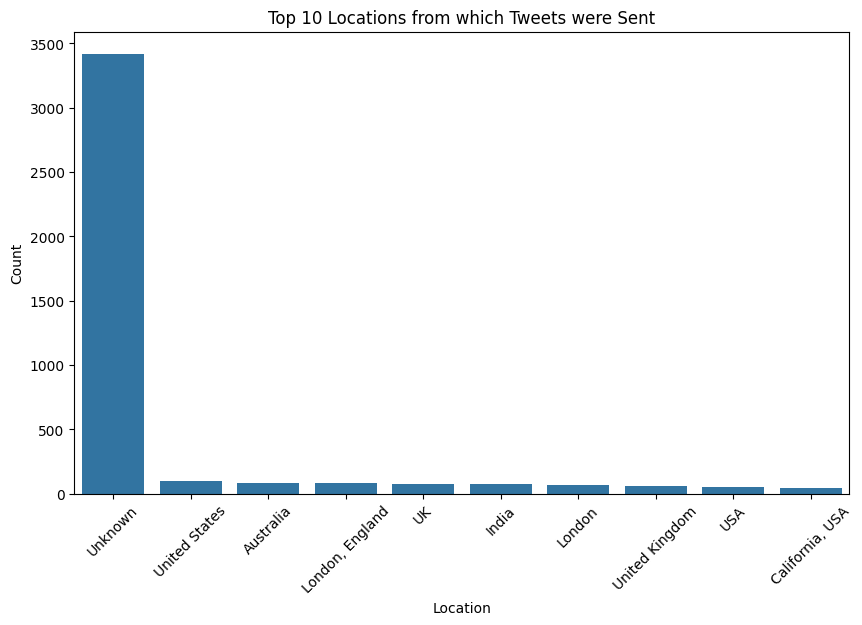

In [11]:
# how many locations are missing
missing_location = df['location'].isnull().sum()
print(f"Number of missing locations: {missing_location}")

# Fill missing locations with 'Unknown'
df['location'].fillna('Unknown', inplace=True)

# top 10 most common locations
top_locations = df['location'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title('Top 10 Locations from which Tweets were Sent')
plt.ylabel('Count')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.show()


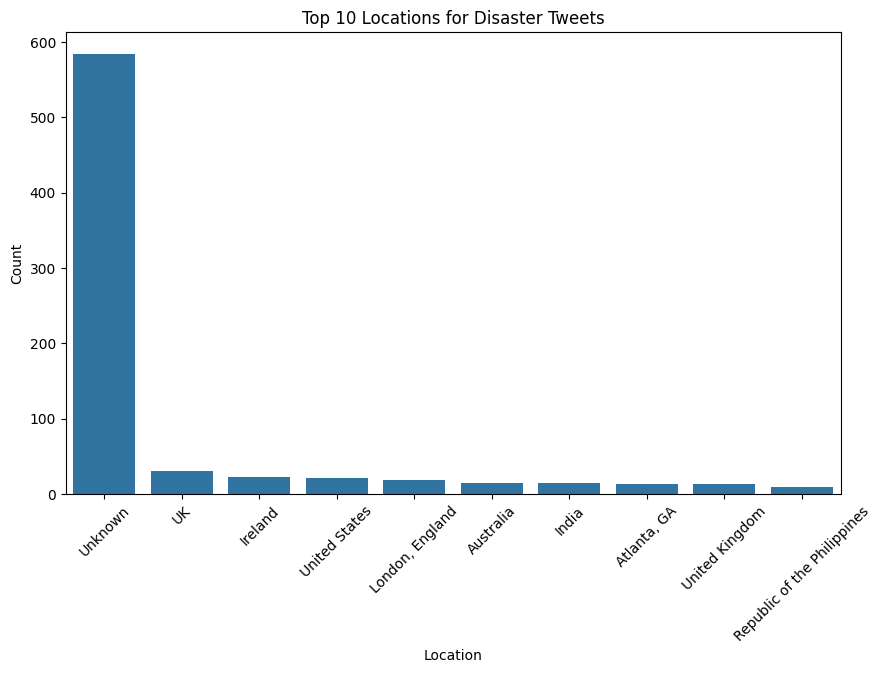

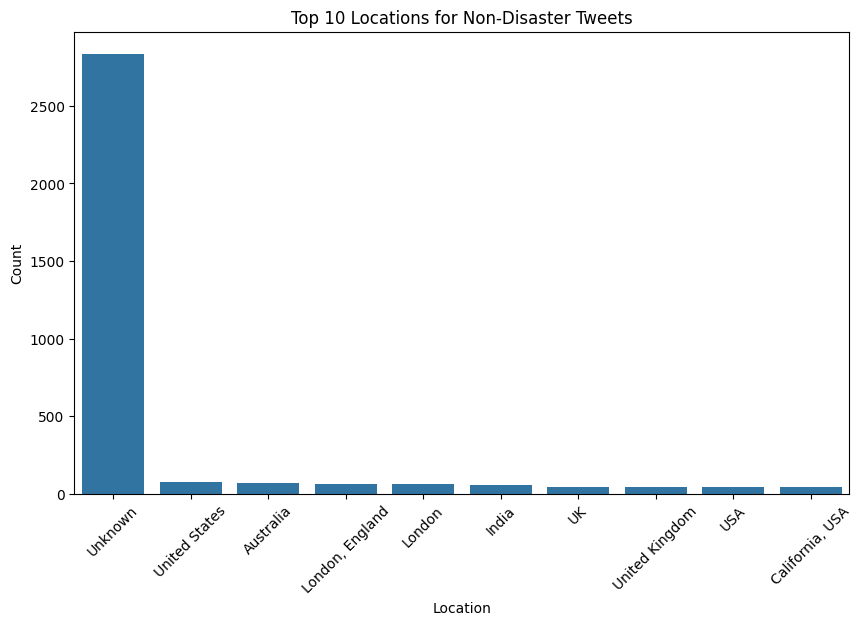

In [12]:
# top 10 locations for disaster tweets
disaster_locations = df[df['target'] == 1]['location'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=disaster_locations.index, y=disaster_locations.values)
plt.title('Top 10 Locations for Disaster Tweets')
plt.ylabel('Count')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.show()

# top 10 locations for non-disaster tweets
non_disaster_locations = df[df['target'] == 0]['location'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=non_disaster_locations.index, y=non_disaster_locations.values)
plt.title('Top 10 Locations for Non-Disaster Tweets')
plt.ylabel('Count')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.show()


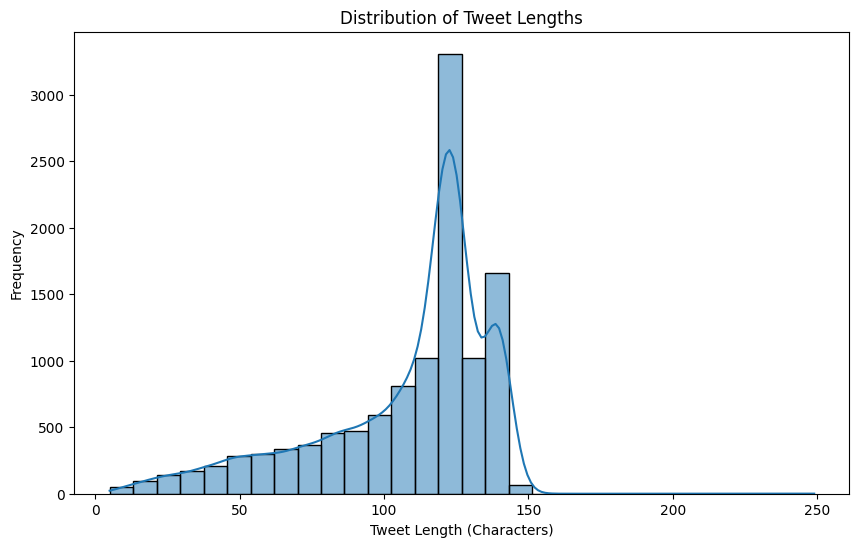

In [13]:
# Add a new column 'tweet_length'
df['tweet_length'] = df['text'].apply(len)

# distribution of tweet lengths
plt.figure(figsize=(10,6))
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Frequency')
plt.show()


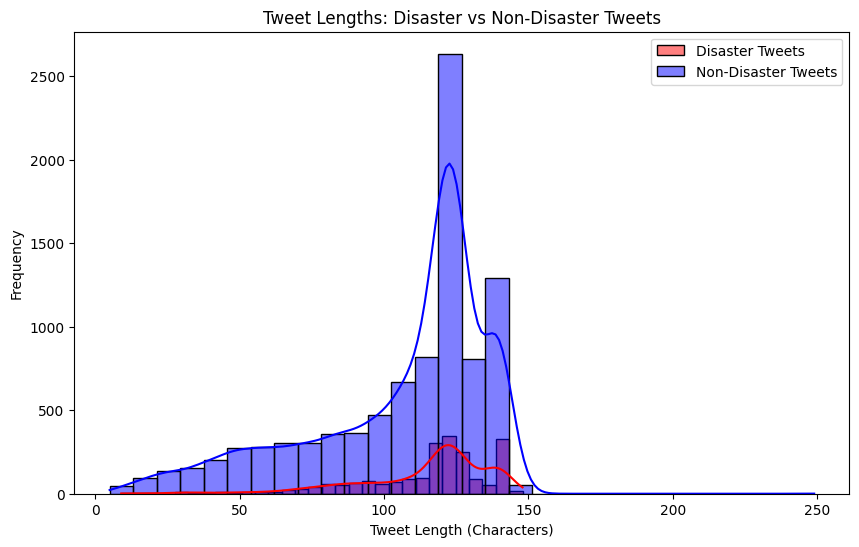

In [14]:
# distribution of tweet lengths for disaster and non-disaster tweets
plt.figure(figsize=(10,6))
sns.histplot(df[df['target'] == 1]['tweet_length'], color='red', label='Disaster Tweets', kde=True, bins=30)
sns.histplot(df[df['target'] == 0]['tweet_length'], color='blue', label='Non-Disaster Tweets', kde=True, bins=30)
plt.title('Tweet Lengths: Disaster vs Non-Disaster Tweets')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


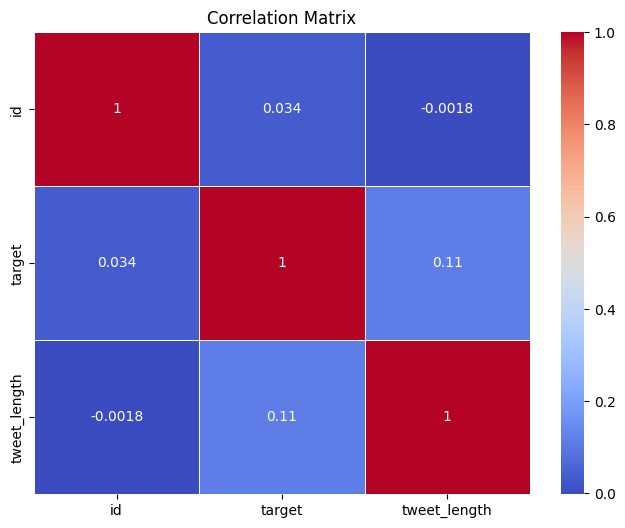

In [15]:
# Fill missing values in 'location' with 'Unknown'
df['location'] = df['location'].fillna('Unknown')
# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()



In [2]:
# Function to convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

In [3]:
# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


In [4]:
# Function to remove user @ references and hashtags
def remove_mentions_and_hashtags(text):
    return re.sub(r'\@\w+|\#', '', text)

In [5]:
# Function to remove extra spaces
def remove_extra_spaces(text):
    return text.strip()

In [6]:
def remove_non_english(text):
    # This will remove all characters that are not English letters, spaces, punctuation, or digits
    return re.sub(r'[^\x00-\x7F]+', '', text)

In [7]:
# Dictionary of common contractions and their expansions
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "I would",
    "i'll": "I will",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who's": "who is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
}

# Function to expand contractions
def expand_contractions(text):
    # Create a regular expression from the contractions dictionary keys
    contractions_pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')

    # Define a function to replace matched contractions
    def replace(match):
        return contractions_dict[match.group(0)]

    # Use the sub function to replace contractions
    expanded_text = contractions_pattern.sub(replace, text)
    return expanded_text

In [10]:
import emoji

# Function to convert emojis to their textual meaning
def convert_emojis_to_text(text):
    # Use the emoji.demojize function to convert emojis to text
    text_with_emojis_converted = emoji.demojize(text, delimiters=(":", ":"))
    return text_with_emojis_converted

In [13]:
def preprocess_text(text):
    text = convert_to_lowercase(text)
    text = remove_urls(text)
    text = remove_mentions_and_hashtags(text)
    text = expand_contractions(text)
    text = convert_emojis_to_text(text)  # Call emoji conversion function here
    text = remove_non_english(text)
    text = remove_extra_spaces(text)
    return text

In [18]:
import emoji

# Function to remove emojis from a given text
def remove_emojis(text):
    # Regular expression pattern to match emojis
    emoji_pattern = re.compile(
        "["  
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # other symbols
        u"\U000024C2-\U0001F251"  # enclosed characters
        "]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)

# Example of integrating this function to remove emojis from the 'location' column
def preprocess_location(location_text):
    return remove_emojis(location_text)

In [19]:
# Load the CSV file
df = pd.read_csv('tweets.csv')

# Apply preprocessing to the text column
df['processed_text'] = df['text'].apply(preprocess_text)

# Apply emoji removal to the 'location' column
df['location'] = df['location'].astype(str).apply(preprocess_location)

# Save the processed data to a new CSV file
new_df = df[['id', 'keyword', 'location', 'processed_text', 'target']]
new_df.to_csv('tweetsv1.csv', index=False)

print("Preprocessing complete and saved to tweetsv1.csv")

Preprocessing complete and saved to tweetsv1.csv


TOKENISATION

*   Word Tokenisation
*   Sentence Tokenisation
*   Character Tokenization
*   SubWord Tokenization





In [1]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vansh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
import pandas as pd
from nltk.tokenize import sent_tokenize, TweetTokenizer
from transformers import AutoTokenizer

# Initialize tokenizers
tweet_tokenizer = TweetTokenizer()
subword_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Define tokenization functions

# 1. Sentence Tokenization
def sentence_tokenize_text(text):
    if isinstance(text, str):
        return sent_tokenize(text)
    else:
        return []

# 2. Subword Tokenization
def subword_tokenize_text(text):
    if isinstance(text, str):
        tokens = subword_tokenizer.tokenize(text)
        return tokens
    else:
        return []

# 3. Character Tokenization
def character_tokenize_text(text):
    if isinstance(text, str):
        return list(text)
    else:
        return []

# 4. Word Tokenization (using TweetTokenizer)
def word_tokenize_text(text):
    if isinstance(text, str):
        return tweet_tokenizer.tokenize(text)
    else:
        return []

# 5. BERT Tokenization
def bert_tokenize_text(text):
    if isinstance(text, str):
        tokens = bert_tokenizer.tokenize(text)
        return tokens
    else:
        return []

# Load your dataset
df = pd.read_csv('tweetsv2.csv')

# Ensure 'processed_text' column is a string
df['processed_text'] = df['processed_text'].astype(str)

# Apply different tokenization methods
df['sentence_tokens'] = df['processed_text'].apply(sentence_tokenize_text)
df['subword_tokens'] = df['processed_text'].apply(subword_tokenize_text)
df['character_tokens'] = df['processed_text'].apply(character_tokenize_text)
df['word_tokens'] = df['processed_text'].apply(word_tokenize_text)
df['bert_tokens'] = df['processed_text'].apply(bert_tokenize_text)

# Display the first few rows of the updated DataFrame
print(df.head())

# Save the updated DataFrame to a CSV file
df.to_csv('tweetsv3.csv', index=False)


LEMMATIZATION

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\vansh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define lemmatization function for tokenized columns
def lemmatize_tokens(tokens):
    if isinstance(tokens, list):
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    else:
        return ''

# Apply lemmatization to each tokenized column, including the BERT token column
df['lemmatized_sentence_tokens'] = df['sentence_tokens'].apply(lemmatize_tokens)
df['lemmatized_subword_tokens'] = df['subword_tokens'].apply(lemmatize_tokens)
df['lemmatized_character_tokens'] = df['character_tokens'].apply(lemmatize_tokens)
df['lemmatized_word_tokens'] = df['word_tokens'].apply(lemmatize_tokens)
df['lemmatized_bert_tokens'] = df['bert_tokens'].apply(lemmatize_tokens)

# Save the updated DataFrame to a CSV file
df.to_csv('tweetsv4.csv', index=False)

# Display the first few rows of the updated DataFrame
print(df.head(15))


    id keyword         location  \
0    0  ablaze              NaN   
1    1  ablaze              NaN   
2    2  ablaze    New York City   
3    3  ablaze   Morgantown, WV   
4    4  ablaze              NaN   
5    5  ablaze               OC   
6    6  ablaze  London, England   
7    7  ablaze           Bharat   
8    8  ablaze     Accra, Ghana   
9    9  ablaze        Searching   
10  10  ablaze              NaN   
11  11  ablaze              NaN   
12  12  ablaze              NaN   
13  13  ablaze        HYDERABAD   
14  14  ablaze         Reno, NV   

                                       processed_text  target  \
0   communal violence in bhainsa, telangana. "ston...       1   
1   telangana: section 144 has been imposed in bha...       1   
2             arsonist sets cars ablaze at dealership       1   
3             arsonist sets cars ablaze at dealership       1   
4   "lord jesus, your love brings freedom and pard...       0   
5   if this child was chinese, this tweet would h

STOP WORD REMOVAL

In [5]:
import pandas as pd
from nltk.corpus import stopwords

# Download NLTK stopwords if not already done
import nltk
nltk.download('stopwords')

# Initialize stop words list
stop_words = set(stopwords.words('english'))

# Define stop word removal function for lemmatized columns
def remove_stopwords_from_text(text):
    if isinstance(text, str):
        tokens = text.split()  # Split the text into tokens
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        return ''

# Load the dataset
df = pd.read_csv('tweetsv4.csv')

# Apply stop word removal to each lemmatized column, including the lemmatized BERT tokens
df['no_stopwords_lemmatized_sentence_tokens'] = df['lemmatized_sentence_tokens'].apply(remove_stopwords_from_text)
df['no_stopwords_lemmatized_subword_tokens'] = df['lemmatized_subword_tokens'].apply(remove_stopwords_from_text)
df['no_stopwords_lemmatized_character_tokens'] = df['lemmatized_character_tokens'].apply(remove_stopwords_from_text)
df['no_stopwords_lemmatized_word_tokens'] = df['lemmatized_word_tokens'].apply(remove_stopwords_from_text)
df['no_stopwords_lemmatized_bert_tokens'] = df['lemmatized_bert_tokens'].apply(remove_stopwords_from_text)

# Save the updated DataFrame to a CSV file
df.to_csv('tweetsv5.csv', index=False)

# Display the first few rows of the updated DataFrame
print(df.head(15))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vansh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


    id keyword         location  \
0    0  ablaze              NaN   
1    1  ablaze              NaN   
2    2  ablaze    New York City   
3    3  ablaze   Morgantown, WV   
4    4  ablaze              NaN   
5    5  ablaze               OC   
6    6  ablaze  London, England   
7    7  ablaze           Bharat   
8    8  ablaze     Accra, Ghana   
9    9  ablaze        Searching   
10  10  ablaze              NaN   
11  11  ablaze              NaN   
12  12  ablaze              NaN   
13  13  ablaze        HYDERABAD   
14  14  ablaze         Reno, NV   

                                       processed_text  target  \
0   communal violence in bhainsa, telangana. "ston...       1   
1   telangana: section 144 has been imposed in bha...       1   
2             arsonist sets cars ablaze at dealership       1   
3             arsonist sets cars ablaze at dealership       1   
4   "lord jesus, your love brings freedom and pard...       0   
5   if this child was chinese, this tweet would h

In [11]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

# Load the CSV file
df = pd.read_csv('tweetsv5.csv')

# Extract the 'no_stopwords_lemmatized_bert_tokens' column
def convert_to_list(text):
    # Check if text is NaN or not a string
    if pd.isna(text) or not isinstance(text, str):
        return []  # Return an empty list for NaN or invalid entries
    # Remove brackets and split by comma or space
    text = text.replace("[", "").replace("]", "").replace("'", "")
    return text.split(", ") if ", " in text else text.split()

# Apply conversion to the column
last_column = df['no_stopwords_lemmatized_bert_tokens'].apply(convert_to_list)

# Train Word2Vec model on the tokenized column
word2vec_model = Word2Vec(sentences=last_column, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average Word2Vec embeddings for each entry
def get_word2vec_embeddings(tokens):
    word_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply Word2Vec embeddings to the column
word2vec_embeddings = np.array([get_word2vec_embeddings(tokens) for tokens in last_column])

# Create a DataFrame and save to CSV
word2vec_df = pd.DataFrame(word2vec_embeddings)
word2vec_df.to_csv('word2vec_vectors.csv', index=False)

# Display the shape of the resulting DataFrame
print("Word2Vec Embeddings Shape:", word2vec_df.shape)


Word2Vec Embeddings Shape: (11370, 100)


VECTORIZATION
*  Bag of Words 
*  Term Frequency-Inverse Document Frequency
*  BERT
*  Word2Vec

In [7]:
import pandas as pd

# Load the dataset
file_path = 'tweetsv5.csv'
df = pd.read_csv(file_path)

# Focus on the 'no_stopwords_lemmatized_word_tokens' column
text_data = df['no_stopwords_lemmatized_word_tokens']


BAG OF WORDS

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the dataset
file_path = 'tweetsv5.csv'
df = pd.read_csv(file_path)

# Extract the 'no_stopwords_lemmatized_word_tokens' column
text_data = df['no_stopwords_lemmatized_word_tokens'].astype(str)

# Initialize the CountVectorizer for Bag of Words
vectorizer_bow = CountVectorizer()

# Apply Bag of Words on the text data
bow_matrix = vectorizer_bow.fit_transform(text_data)

# Convert to DataFrame
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_bow.get_feature_names_out())

# Add the BoW features to the original DataFrame
df = pd.concat([df, bow_df], axis=1)

# Display the first few rows of the updated DataFrame
print(df.head())

# Save the updated DataFrame to a new CSV file
df.to_csv('tweets_bow.csv', index=False)


   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                      processed_text  target  \
0  communal violence in bhainsa, telangana. "ston...       1   
1  telangana: section 144 has been imposed in bha...       1   
2            arsonist sets cars ablaze at dealership       1   
3            arsonist sets cars ablaze at dealership       1   
4  "lord jesus, your love brings freedom and pard...       0   

                                     sentence_tokens  \
0  ['communal violence in bhainsa, telangana.', '...   
1  ['telangana: section 144 has been imposed in b...   
2        ['arsonist sets cars ablaze at dealership']   
3        ['arsonist sets cars ablaze at dealership']   
4  ['"lord jesus, your love brings freedom and pa...   

                                      subword_tokens  \
0  ['communal', 'violen

TF-IDF

In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataset
file_path = 'tweetsv5.csv'
df = pd.read_csv(file_path)

# Extract the 'no_stopwords_lemmatized_word_tokens' column
text_data = df['no_stopwords_lemmatized_word_tokens'].astype(str)

# Initialize the TF-IDF Vectorizer
vectorizer_tfidf = TfidfVectorizer()

# Apply TF-IDF on the text data
tfidf_matrix = vectorizer_tfidf.fit_transform(text_data)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_tfidf.get_feature_names_out())

# Add the TF-IDF features to the original DataFrame
df = pd.concat([df, tfidf_df], axis=1)

# Display the first few rows of the updated DataFrame
print(df.head())

# Save the updated DataFrame to a new CSV file
df.to_csv('tweets_tfidf.csv', index=False)


   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                      processed_text  target  \
0  communal violence in bhainsa, telangana. "ston...       1   
1  telangana: section 144 has been imposed in bha...       1   
2            arsonist sets cars ablaze at dealership       1   
3            arsonist sets cars ablaze at dealership       1   
4  "lord jesus, your love brings freedom and pard...       0   

                                     sentence_tokens  \
0  ['communal violence in bhainsa, telangana.', '...   
1  ['telangana: section 144 has been imposed in b...   
2        ['arsonist sets cars ablaze at dealership']   
3        ['arsonist sets cars ablaze at dealership']   
4  ['"lord jesus, your love brings freedom and pa...   

                                      subword_tokens  \
0  ['communal', 'violen

BERT


In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel

file_path = 'tweetsv5.csv'
df = pd.read_csv(file_path)
# Extract the 'no_stopwords_lemmatized_word_tokens' column
text_data = df['no_stopwords_lemmatized_word_tokens'].astype(str)

# Load BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

# Function to generate BERT embeddings
def get_bert_embeddings(text):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)

    # Generate embeddings with BERT model
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the mean of token embeddings (pooled output)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embeddings

# Apply BERT embeddings to the text data
bert_embeddings = text_data.apply(get_bert_embeddings)

# Convert to DataFrame
bert_df = pd.DataFrame(bert_embeddings.tolist(), columns=[f'bert_{i}' for i in range(bert_embeddings.iloc[0].shape[0])])

# Add the BERT features to the original DataFrame
df = pd.concat([df, bert_df], axis=1)

# Display the first few rows of the updated DataFrame
print(df.head())

# Save the updated DataFrame to a new CSV file
df.to_csv('tweets_bert.csv', index=False)


   id keyword        location  \
0   0  ablaze             NaN   
1   1  ablaze             NaN   
2   2  ablaze   New York City   
3   3  ablaze  Morgantown, WV   
4   4  ablaze             NaN   

                                      processed_text  target  \
0  communal violence in bhainsa, telangana. "ston...       1   
1  telangana: section 144 has been imposed in bha...       1   
2            arsonist sets cars ablaze at dealership       1   
3            arsonist sets cars ablaze at dealership       1   
4  "lord jesus, your love brings freedom and pard...       0   

                                     sentence_tokens  \
0  ['communal violence in bhainsa, telangana.', '...   
1  ['telangana: section 144 has been imposed in b...   
2        ['arsonist sets cars ablaze at dealership']   
3        ['arsonist sets cars ablaze at dealership']   
4  ['"lord jesus, your love brings freedom and pa...   

                                      subword_tokens  \
0  ['communal', 'violen

WORD2VEC

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

# Load the CSV file
df = pd.read_csv('tweetsv5.csv')

# Extract the 'no_stopwords_lemmatized_bert_tokens' column
def convert_to_list(text):
    # Check if text is NaN or not a string
    if pd.isna(text) or not isinstance(text, str):
        return []  # Return an empty list for NaN or invalid entries
    # Remove brackets and split by comma or space
    text = text.replace("[", "").replace("]", "").replace("'", "")
    return text.split(", ") if ", " in text else text.split()

# Apply conversion to the column
last_column = df['no_stopwords_lemmatized_bert_tokens'].apply(convert_to_list)

# Train Word2Vec model on the tokenized column
word2vec_model = Word2Vec(sentences=last_column, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average Word2Vec embeddings for each entry
def get_word2vec_embeddings(tokens):
    word_embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Apply Word2Vec embeddings to the column
word2vec_embeddings = np.array([get_word2vec_embeddings(tokens) for tokens in last_column])

# Create a DataFrame and save to CSV
word2vec_df = pd.DataFrame(word2vec_embeddings)
word2vec_df.to_csv('word2vec_vectors.csv', index=False)

# Display the shape of the resulting DataFrame
print("Word2Vec Embeddings Shape:", word2vec_df.shape)

HANDLING IMBALANCE

Verifying the dataset is imbalanced


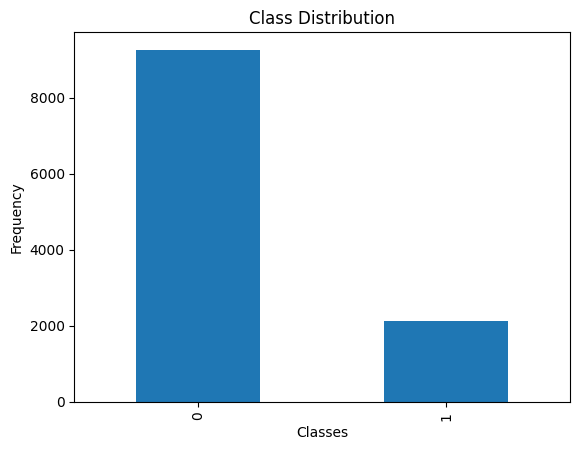

Class distribution:
 target
0    9256
1    2114
Name: count, dtype: int64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to check class distribution and identify imbalance
def check_class_imbalance(df, target_column):
    # Get class distribution
    class_counts = df[target_column].value_counts()
    
    # Plot class distribution
    class_counts.plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.show()
    
    # Print class distribution
    print("Class distribution:\n", class_counts)
    return class_counts

# Load the CSV file
df = pd.read_csv('tweetsv1.csv')

# Check for class imbalance in the 'target' column
class_counts = check_class_imbalance(df, 'target')


- RANDOM UNDERSAMPLING

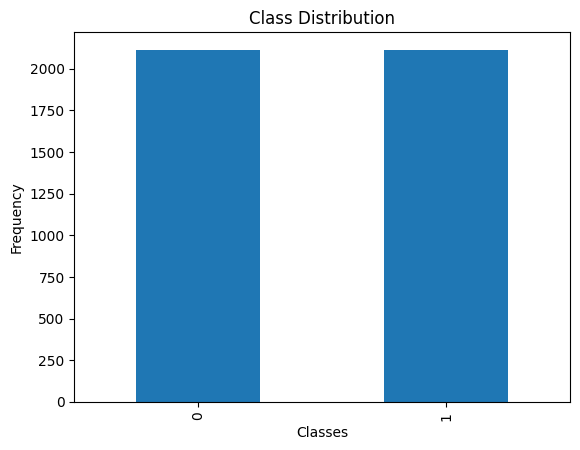

Class distribution:
 target
0    2114
1    2114
Name: count, dtype: int64


target
0    2114
1    2114
Name: count, dtype: int64

In [3]:
from sklearn.utils import resample

# Function to perform random undersampling
def random_undersampling(df, target_column):
    # Separate majority and minority classes
    majority_class = df[df[target_column] == df[target_column].value_counts().idxmax()]
    minority_class = df[df[target_column] == df[target_column].value_counts().idxmin()]
    
    # Perform undersampling of the majority class
    majority_undersampled = resample(majority_class, 
                                     replace=False,  # Sample without replacement
                                     n_samples=len(minority_class),  # Match minority class size
                                     random_state=42)  # Reproducibility
    
    # Combine minority class and undersampled majority class
    undersampled_df = pd.concat([majority_undersampled, minority_class])
    
    return undersampled_df

# Apply random undersampling to balance the dataset
undersampled_df = random_undersampling(df, 'target')

# Check class distribution after undersampling
check_class_imbalance(undersampled_df, 'target')


- RANDOM OVERSAMPLING

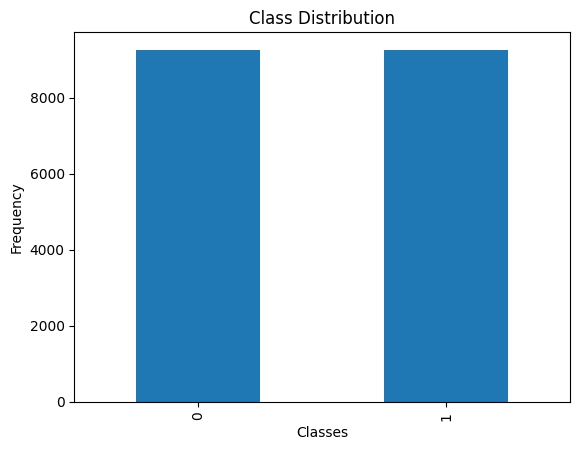

Class distribution:
 target
0    9256
1    9256
Name: count, dtype: int64


target
0    9256
1    9256
Name: count, dtype: int64

In [4]:
# Function to perform random oversampling
def random_oversampling(df, target_column):
    # Separate majority and minority classes
    majority_class = df[df[target_column] == df[target_column].value_counts().idxmax()]
    minority_class = df[df[target_column] == df[target_column].value_counts().idxmin()]
    
    # Perform oversampling of the minority class
    minority_oversampled = resample(minority_class, 
                                    replace=True,  # Sample with replacement
                                    n_samples=len(majority_class),  # Match majority class size
                                    random_state=42)  # Reproducibility
    
    # Combine oversampled minority class and majority class
    oversampled_df = pd.concat([majority_class, minority_oversampled])
    
    return oversampled_df

# Apply random oversampling to balance the dataset
oversampled_df = random_oversampling(df, 'target')

# Check class distribution after oversampling
check_class_imbalance(oversampled_df, 'target')


- SMOTE

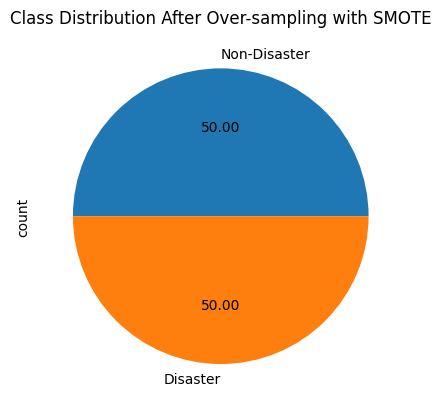

target
1    9256
0    9256
Name: count, dtype: int64


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('tweetsv1.csv')
df['processed_text'] = df['processed_text'].fillna('')

# Step 1: Convert text data to numerical data using TF-IDF
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['processed_text'])  # Using 'processed_text' column
y = df['target']

# Step 2: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Step 3: Visualize the new class distribution after SMOTE
ax = y_resampled.value_counts().plot.pie(autopct='%.2f', labels=['Non-Disaster', 'Disaster'])
_ = ax.set_title("Class Distribution After Over-sampling with SMOTE")
plt.show()

# Output class distribution
print(y_resampled.value_counts())


In [ ]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(df['processed_text'])  # Using 'processed_text' column
y = df['target']

# Step 2: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Step 3: Visualize the new class distribution after SMOTE
ax = y_resampled.value_counts().plot.pie(autopct='%.2f', labels=['Non-Disaster', 'Disaster'])
_ = ax.set_title("Class Distribution After Over-sampling with SMOTE")
plt.show()

# Output class distribution
print(y_resampled.value_counts())


In [17]:
# Step 4: Convert the resampled data back to a DataFrame for saving
# The resampled TF-IDF data is in sparse matrix format, so we'll need to convert it into a dense format.
df_resampled = pd.DataFrame(X_resampled.todense(), columns=tfidf.get_feature_names_out())  # Convert to DataFrame
df_resampled['target'] = y_resampled  # Add the resampled target column back to the DataFrame

# Step 5: Save the balanced dataset to a new CSV file
df_resampled.to_csv('tweetsv2.csv', index=False)

print("Balanced dataset created and saved to 'balanced_disaster_data.csv'")

Balanced dataset created and saved to 'balanced_disaster_data.csv'


MODEL TRAINING

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('tweets_bert.csv')

# Identify BERT embedding columns
bert_columns = [col for col in df.columns if col.startswith('bert_')]

# Ensure BERT embeddings are numerical
df[bert_columns] = df[bert_columns].apply(pd.to_numeric, errors='coerce')

# Replace NaN values with 0 using SimpleImputer
imputer = SimpleImputer(strategy='constant', fill_value=0)
X = imputer.fit_transform(df[bert_columns])

# Define target variable
y = df['target'].fillna(0).astype(int)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
def train_evaluate_and_plot(model, X_train, X_test, y_train, y_test, model_name, metrics_dict):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Store metrics for comparison
    metrics_dict[model_name] = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }
    
    # Print results
    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred)}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Disaster', 'Disaster'], yticklabels=['Non-Disaster', 'Disaster'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


- Logistic Regression

Logistic Regression Accuracy: 0.88
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1878
           1       0.69      0.62      0.65       396

    accuracy                           0.88      2274
   macro avg       0.80      0.78      0.79      2274
weighted avg       0.88      0.88      0.88      2274



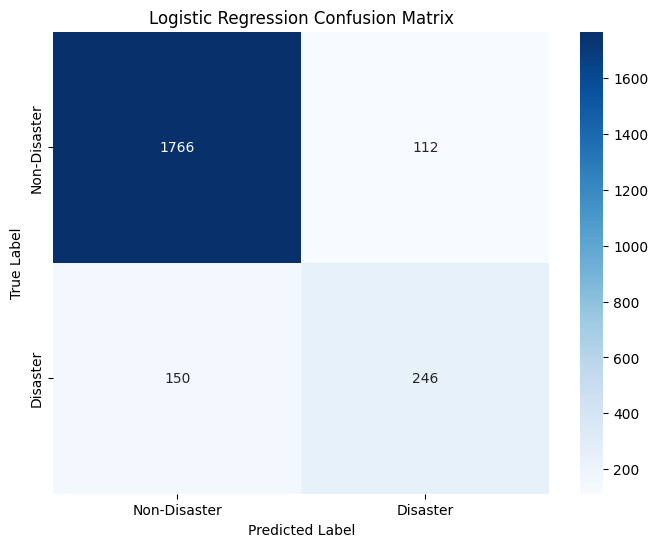

In [16]:
from sklearn.linear_model import LogisticRegression
# Dictionary to store metrics for comparison
metrics_dict = {}
log_reg = LogisticRegression(max_iter=1000)
train_evaluate_and_plot(log_reg, X_train, X_test, y_train, y_test, "Logistic Regression", metrics_dict)


- Naive Bayes

Naive Bayes Accuracy: 0.86
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1878
           1       0.69      0.37      0.48       396

    accuracy                           0.86      2274
   macro avg       0.78      0.67      0.70      2274
weighted avg       0.85      0.86      0.84      2274



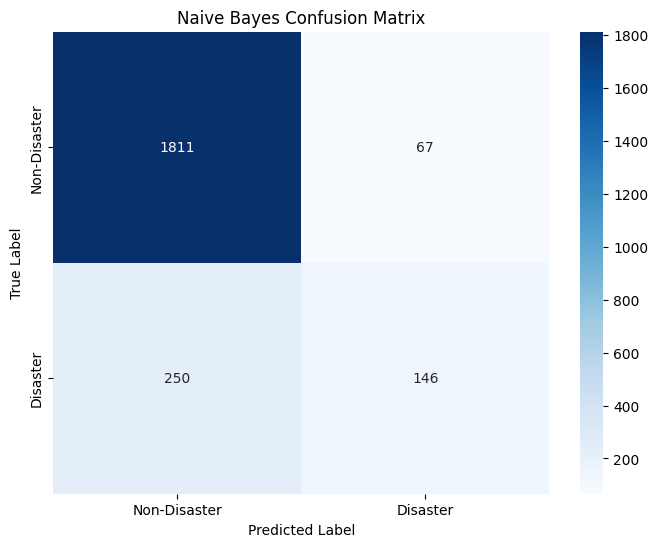

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

# Min-Max scaling for Naive Bayes
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nb_model = MultinomialNB()
train_evaluate_and_plot(nb_model, X_train_scaled, X_test_scaled, y_train, y_test, "Naive Bayes", metrics_dict)


- Random Forest

Random Forest Accuracy: 0.88
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1878
           1       0.83      0.40      0.54       396

    accuracy                           0.88      2274
   macro avg       0.86      0.69      0.73      2274
weighted avg       0.88      0.88      0.86      2274



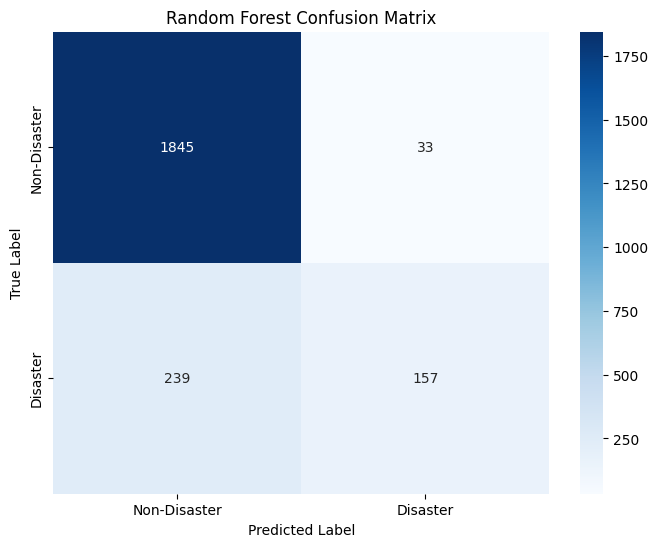

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
train_evaluate_and_plot(rf_model, X_train, X_test, y_train, y_test, "Random Forest", metrics_dict)


- XGBoost

c:\Users\vansh\anaconda3\envs\trch\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.91
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1878
           1       0.79      0.62      0.69       396

    accuracy                           0.91      2274
   macro avg       0.86      0.79      0.82      2274
weighted avg       0.90      0.91      0.90      2274



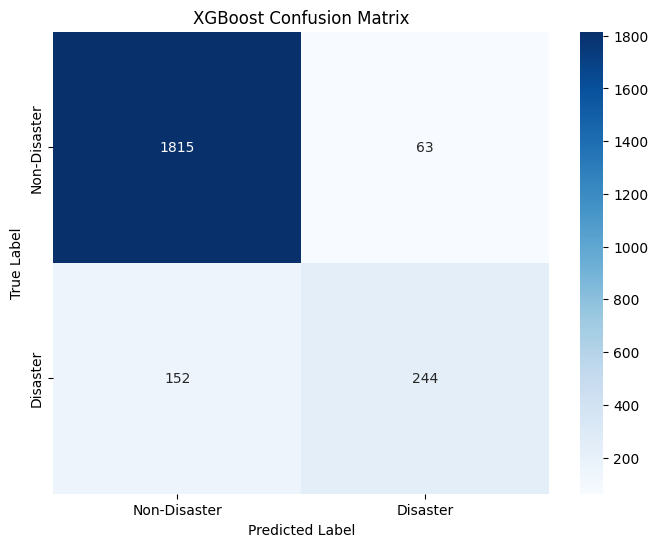

In [19]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
train_evaluate_and_plot(xgb_model, X_train, X_test, y_train, y_test, "XGBoost", metrics_dict)


- Comparison Chart

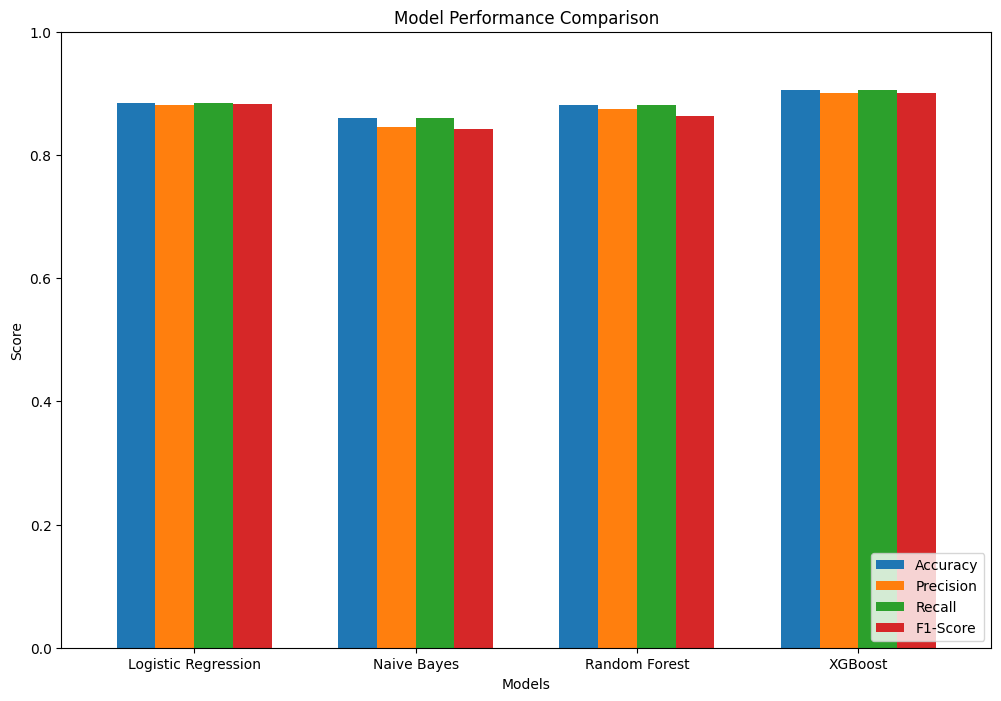

In [20]:
def plot_comparison_chart(metrics_dict):
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_df.plot(kind='bar', figsize=(12, 8), width=0.7)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

# Plot the comparison chart for all models
plot_comparison_chart(metrics_dict)
